# Prediction of the perturbed genes via translation of image-based gene perturbation to regulatory gene embedding

---

This notebook uses the pre-computed image-based gene embeddings to learn a map to translate those to regulatory gene embeddings, we had previously obtained by embedding the computed gene-gene interactome. For the latter we use the embeddings obtained when inputting the cluster structure of the CMAP signatures of the 41 overexpression conditions that we had identified in the previous study to impact the chromatin organization. Since the embeddings are thus independent of the used image data, we can use these embeddings optimally to validate the performance of our pipeline now using the JUMP instead of the Rohban et al data set. In contrast to the data set from Rohban et al (2017) the JUMP data set contains a total of 175 overexpression conditions for which the corresponding gene targets are contained in the inferred gene-gene interactome, i.e. we know their corresponding regulatory gene embeddings and can thus predict any of these. As a consequence, we will validate our pipeline on these conditions.

In particular, the validation procedure will look as follows:
1. Given the image embeddings of the cells in the 175 OE conditions, we will obtain the corresponding gene perturbation embeddings as the condition-wise mean of these embeddings.
2. We will select the 31 OE conditions which are the subset of the 41 impactful gene perturbation settings from the Rohban et al. (2017) data set that are part of the selected 175 conditions of the JUMP data set.
3. We will learn a NTK-based map as described in our paper using these 31 condition that given a image-based gene perturbation embedding predicts the corresponding regulatory gene embedding.
4. Using the learned map, we will obtain predictions of the regulatory gene embeddings for the perturbed gene targets of the remaining 144/175 OE conditions in our data set.
5. Finally, we evaluate the prediction performance for those 144 OE conditions using the k-nearest neighbor accuracy and compare those against a baseline that is equivalent to random chance as described in the paper.

---

## Environmental setup

First, we load in all required software packages and define the required functions.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import copy
from torch import nn
from torch.optim import Adam
import sys
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import matplotlib as mpl
from sklearn.preprocessing import normalize
import os
import rff
import pickle
import traceback
import time
from sklearn.linear_model import LinearRegression

sys.path.append("../../../..")

from src.utils.notebooks.translation.analysis import *
from src.data.datasets import IndexedTensorDataset
from src.utils.basic.io import get_genesets_from_gmt_file

mpl.rcParams["figure.dpi"] = 600


seed = 1234

device = "cuda:0"

%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [216]:
class SyntheticInterventionModel:
    def __init__(self):
        super().__init__()
        self.alpha = None
        self.X_train = None
        self.Y_train = None

    def fit(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        return self

    def predict(self, x_test):
        self.alpha = np.matmul(x_test, np.linalg.pinv(self.X_train))
        y_test = np.matmul(self.alpha, self.Y_train)
        return y_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
class MeanModel:
    def __init__(self):
        super().__init__()
        self.Y_train = None

    def fit(self, X_train, Y_train):
        self.Y_train = Y_train
        return self

    def predict(self, x_test=None):
        y_test = self.Y_train.mean(axis=0).reshape(1, -1)
        return y_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
class RandomModel:
    def __init__(self):
        super().__init__()
        self.Y_train = None

    def fit(self, X_train, Y_train):
        self.Y_train = Y_train
        return self

    def predict(self, x_test=None):
        test_idc = np.random.randint(0, len(self.Y_train))
        y_test = self.Y_train[test_idc].reshape(1, -1)
        return y_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
def compute_area_under_the_knn_curve(knn_acc_results, max_k=51):
    knn_accs = knn_acc_results.loc[knn_acc_results.k < max_k, "knn_acc"]
    return np.sum(knn_accs) / max_k

<IPython.core.display.Javascript object>

In [3]:
def get_knn_hit_data(nn_dict):
    idc = []
    hits = []
    for k, v in nn_dict.items():
        idc.append(k)
        hits.append(np.where(v == k)[0])
    hit_results = pd.DataFrame(np.array(hits), columns=["knn_hit"], index=idc)
    return hit_results

<IPython.core.display.Javascript object>

In [4]:
def get_knn_hit_data(nn_dict):
    idc = []
    hits = []
    for k, v in nn_dict.items():
        idc.append(k)
        hits.append(np.where(v == k)[0])
    hit_results = pd.DataFrame(np.array(hits), columns=["knn_hit"], index=idc)
    return hit_results

<IPython.core.display.Javascript object>

In [5]:
from numpy.linalg import solve


class NTK:
    def __init__(self, reg=1):
        super().__init__()
        self.reg = reg
        self.sol = None
        self.Xtrain = None

    def kernel(self, pair1, pair2):

        out = pair1 @ pair2.T + 1
        N1 = np.sum(np.power(pair1, 2), axis=-1).reshape(-1, 1) + 1
        N2 = np.sum(np.power(pair2, 2), axis=-1).reshape(-1, 1) + 1

        XX = np.sqrt(N1 @ N2.T)
        out = out / XX

        out = np.clip(out, -1, 1)

        first = (
            1
            / np.pi
            * (out * (np.pi - np.arccos(out)) + np.sqrt(1.0 - np.power(out, 2)))
            * XX
        )
        sec = 1 / np.pi * out * (np.pi - np.arccos(out)) * XX
        out = first + sec

        C = 1
        return out / C

    def fit(self, Xtrain, ytrain):
        K = self.kernel(Xtrain, Xtrain)
        sol = solve(K + self.reg * np.eye(len(K)), ytrain).T
        self.sol = sol
        self.Xtrain = Xtrain
        return self

    def predict(self, X):
        K = self.kernel(self.Xtrain, X)
        return (self.sol @ K).T

<IPython.core.display.Javascript object>

In [6]:
def get_input_and_target_features(
    X_train,
    Y_train,
    x_test,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding="positional",
    append_neighbor_embs=None,
    rff_sigma=1,
    cache_dir=None,
):
    pert_train_samples = list(X_train.index)
    test_target = list(x_test.index)[0]
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    x_test = np.array(x_test).reshape(1, -1)

    if use_y_train_mean:
        Y_train_mean = np.repeat(
            Y_train.mean(axis=0).reshape(1, -1), len(X_train), axis=0
        )
        X_train = np.concatenate([X_train, Y_train_mean], axis=-1)
        x_test = np.concatenate([x_test, Y_train_mean[0].reshape(1, -1)], axis=-1)

    ## Use Random Fourier Features of nearest neighbors of the training image embeddings
    if n_neighbors_weights_features > 0:
        nn = NearestNeighbors(n_neighbors=n_neighbors_weights_features)
        nn = nn.fit(X_train)
        X_train_and_test = np.concatenate([X_train, x_test], axis=0)
        neighbors_idcs = nn.kneighbors(X_train_and_test, return_distance=False)

        # Use cached SI coefficients if those are available to redce run-time
        # If the file does not exist but a cache directory is given - the SI coefficients are cached.
        try:
            filehandler = open(
                os.path.join(
                    cache_dir,
                    "neighbor_weights_{}_{}.pkl".format(
                        test_target, n_neighbors_weights_features
                    ),
                ),
                "rb",
            )
            neighbor_weights = pickle.load(filehandler)
            filehandler.close()
        except Exception:
            neighbor_weights = []
            for i in range(len(X_train_and_test)):
                neighbors_idc = neighbors_idcs[i]
                neighbors = X_train[neighbors_idc]
                neighbor_weight = np.matmul(
                    X_train_and_test[i], np.linalg.pinv(neighbors)
                )
                neighbor_weights.append(neighbor_weight)
            neighbors_weights = np.array(neighbor_weights)

            if cache_dir is not None:
                os.makedirs(cache_dir, exist_ok=True)
                filehandler = open(
                    os.path.join(
                        cache_dir,
                        "neighbor_weights_{}_{}.pkl".format(
                            test_target, n_neighbors_weights_features
                        ),
                    ),
                    "wb",
                )
                pickle.dump(neighbor_weights, filehandler)
                filehandler.close()

        neighbor_weights = torch.FloatTensor(neighbor_weights)
        if neighbor_weight_encoding == "positional":
            encoding = rff.layers.PositionalEncoding(
                sigma=rff_sigma, m=n_weight_encodings
            )
        elif neighbor_weight_encoding == "gauss":
            encoding = rff.layers.GaussianEncoding(
                sigma=rff_sigma,
                input_size=neighbor_weights.size(-1),
                encoded_size=n_weight_encodings,
            )
        neighbor_weights = encoding(neighbor_weights).cpu().detach().numpy()

        X_train = np.concatenate([X_train, neighbor_weights[:-1]], axis=-1)
        x_test = np.concatenate([x_test, neighbor_weights[-1].reshape(1, -1)], axis=-1)

        # If desired append embeddings of the nearest neighbors (imaging or regulatory) as additional features
        if append_neighbor_embs is not None:
            neighbor_embs = []
            for i in range(len(X_train_and_test)):
                neighbors_idc = neighbors_idcs[i]
                if append_neighbor_embs == "images":
                    neighbors = X_train[neighbors_idc]
                elif append_neighbor_embs == "genes":
                    neighbors = Y_train[neighbors_idc]
                else:
                    raise NotImplementedError
                neighbor_embs.append(neighbors.reshape(-1))
            neighbor_embs = np.array(neighbor_embs)
            X_train = np.concatenate([X_train, neighbor_embs[:-1]], axis=-1)
            x_test = np.concatenate([x_test, neighbor_embs[-1].reshape(1, -1)], axis=-1)
    return X_train, Y_train, x_test

<IPython.core.display.Javascript object>

In [132]:
def get_prediction_for_model(
    X_train,
    Y_train,
    x_test,
    model_type="synthetic_intervention",
    model_params_dict=None,
    model=None,
    Y_all=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    normalize_prediction=False,
):
    start_time = time.time()
    # Get potentially transformed input and target features
    X_train, Y_train, x_test = get_input_and_target_features(
        X_train=X_train,
        Y_train=Y_train,
        x_test=x_test,
        use_y_train_mean=use_y_train_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
    )

    # print("Get features", time.time()-start_time)

    # Initialize model
    if model_type == "synthetic_intervention":
        model = SyntheticInterventionModel()
    elif model_type == "linear_regression":
        model = LinearRegression()
    elif model_type == "kernel_regression":
        if model_params_dict is None:
            model = KernelRidge()
        else:
            model = KernelRidge(**model_params_dict)
    elif model_type == "mean":
        model = MeanModel()
    elif model_type == "mean_all":
        model = MeanModel()
        Y_train = np.array(Y_all)
    elif model_type == "ntk":
        if model_params_dict is not None:
            model = NTK(**model_params_dict)
        else:
            model = NTK()
    elif model_type == "random":
        model = RandomModel()
        Y_train = np.array(Y_all)
    else:
        if model is not None:
            model = model.fit(X_train, Y_train)
        else:
            raise NotImplementedError

    # Fit model and predict
    model = model.fit(X_train, Y_train)
    y_test = model.predict(x_test)

    if normalize_prediction:
        y_test = normalize(Y_test)

    # print("Total time", time.time() - start_time)
    return y_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [273]:
def get_jump_nn_prediction_dict(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    model_type="synthethic_intervention",
    model_params_dict=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    model=None,
    permute=False,
    debug=False,
    return_predicted_embeddings=False,
):
    nn_pred_dict = {}
    emb_pred_dict = {}

    # Randomly permute both embeddings to compute a random baseline
    if permute:
        reg_embs = pd.DataFrame(
            np.random.permutation(np.array(reg_embs)),
            index=reg_embs.index,
            columns=reg_embs.columns,
        )
        pert_embs = pd.DataFrame(
            np.random.permutation(np.array(pert_embs)),
            index=pert_embs.index,
            columns=pert_embs.columns,
        )

    # Identify genes with both corresponding perturbation and regulatory gene embeddings
    shared_targets = set(reg_embs.index).intersection(pert_embs.index)
    # Focus on the perturbation gene embeddings with corresponding regulatory gene embeddings
    pert_embs = pert_embs.loc[list(shared_targets)]

    # Estimate the NearestNeighbor graph of the regulatory gene embeddings using euclidean distances
    reg_nn = NearestNeighbors(n_neighbors=len(reg_embs))
    reg_samples = np.array(list(reg_embs.index))
    reg_nn.fit(np.array(reg_embs))

    # Extract perturbation gene names
    pert_samples = np.array(list(pert_embs.index))

    # Identify the test and train samples as the perturbation gene embeddings of the hold-out gene target
    # and all others respectively
    X_train = pert_embs.loc[train_targets]
    Y_train = reg_embs.loc[train_targets]
    X_train = X_train.sort_index()
    Y_train = Y_train.loc[list(X_train.index)]
    for test_target in test_targets:
        x_test = pert_embs.loc[pert_samples == test_target]

        # Get the predicted regulatory gene embedding for the hold-out gene target
        y_test = get_prediction_for_model(
            X_train=X_train,
            Y_train=Y_train,
            x_test=x_test,
            model_type=model_type,
            model_params_dict=model_params_dict,
            use_y_train_mean=use_y_train_mean,
            n_neighbors_weights_features=n_neighbors_weights_features,
            n_weight_encodings=n_weight_encodings,
            neighbor_weight_encoding=neighbor_weight_encoding,
            append_neighbor_embs=append_neighbor_embs,
            rff_sigma=rff_sigma,
            model=model,
            Y_all=reg_embs,
        )
        emb_pred_dict[test_target] = y_test
        # Identify the sorted nearest neighbor list of the prediction among all regulatory gene embeddings
        reg_nns = reg_samples[reg_nn.kneighbors(y_test, return_distance=False)][0]
        nn_pred_dict[test_target] = reg_nns

        if not permute and debug:
            print(
                model_type,
                test_target,
                np.where(reg_nns == test_target)[0],
                reg_nns[:5],
            )
            # print(y_test)

    # Return a dictionary with the key identifying the hold-out gene target and the corresponding value the
    # names of the regulatory gene embeddings closest to the prediction in increasing euclidean distance
    if not return_predicted_embeddings:
        return nn_pred_dict
    else:
        return nn_pred_dict, emb_pred_dict

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
def get_knn_acc_from_nn_dict(nn_dict, ks=list(range(1, 51))):
    # Function to compute for varying ks whether or not the regulatory gene embedding of the hold-out target
    # is among the k-nearest neighbors of the prediction using the nearest neighbor dictionary of the prediction
    idc = []
    topk_dict = {}
    for target, nns in nn_dict.items():
        idc.append(target)
        for k in ks:
            if "top-{}".format(k) not in topk_dict:
                topk_dict["top-{}".format(k)] = []
            topk_dict["top-{}".format(k)].append(int(target in list(nns)[:k]))
    topk_result = pd.DataFrame(topk_dict, index=idc)
    return topk_result

<IPython.core.display.Javascript object>

In [70]:
def get_jump_knn_acc_for_model(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    model_type="synthetic_intervention",
    model=None,
    model_params_dict=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    n_weight_encodings=10,
    rff_sigma=1,
    ks=None,
):
    # Function to compute the nearest neighbor accuracy for a given set of perturbation and
    # regulatory gene embeddings for a specified model type
    if ks is None:
        ks = list(range(1, 51))
    knn_acc_results = {"knn_acc": [], "k": []}

    # Get nearest-neighbor prediction dictionary
    nn_dict = get_jump_nn_prediction_dict(
        pert_embs=pert_embs,
        reg_embs=reg_embs,
        train_targets=train_targets,
        test_targets=test_targets,
        model_type=model_type,
        model=model,
        model_params_dict=model_params_dict,
        use_y_train_mean=use_y_train_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
        permute=False,
    )
    # print(nn_dict)
    knn_acc = get_knn_acc_from_nn_dict(nn_dict, ks=ks)
    avg_knn_acc = knn_acc.mean()
    for k in ks:
        knn_acc_results["knn_acc"].append(avg_knn_acc.loc["top-{}".format(k)])
        knn_acc_results["k"].append(k)
    knn_acc_results = pd.DataFrame(knn_acc_results)
    return knn_acc_results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
def get_jump_perm_knn_acc_for_model(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    model_type="synthetic_intervention",
    model_params_dict=None,
    model=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    ks=None,
    b=500,
    random_state=1234,
):
    # Function that also computes the knn accuracy for a given model/type but randomly permutes the perturbation
    # and regulatory gene embeddings to establish a random baseline

    np.random.seed(random_state)
    if ks is None:
        ks = list(range(1, 51))
    knn_acc_results = {"knn_acc": [], "k": []}
    for i in tqdm(range(b)):
        nn_dict = get_jump_nn_prediction_dict(
            pert_embs=pert_embs,
            reg_embs=reg_embs,
            train_targets=train_targets,
            test_targets=test_targets,
            model_type=model_type,
            model_params_dict=model_params_dict,
            use_y_train_mean=use_y_train_mean,
            n_neighbors_weights_features=n_neighbors_weights_features,
            n_weight_encodings=n_weight_encodings,
            neighbor_weight_encoding=neighbor_weight_encoding,
            append_neighbor_embs=append_neighbor_embs,
            rff_sigma=rff_sigma,
            model=model,
            permute=True,
        )
        knn_acc = get_knn_acc_from_nn_dict(nn_dict, ks=ks)
        avg_knn_acc = knn_acc.mean()
        for k in ks:
            knn_acc_results["knn_acc"].append(avg_knn_acc.loc["top-{}".format(k)])
            knn_acc_results["k"].append(k)
    knn_acc_results = pd.DataFrame(knn_acc_results)
    return knn_acc_results

<IPython.core.display.Javascript object>

In [12]:
def plot_translation_performance(
    results,
    hue,
    ymax,
    title="",
    random_baseline=None,
    mean_baseline=None,
    mean_train_baseline=None,
    figsize=[9, 6],
    cmap=None,
    style=None,
    style_order=None,
    param_title=None,
    legend_title="Model",
    alpha=0.8,
):
    sns.set_style("whitegrid")
    if param_title is None:
        param_title = hue
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.lineplot(
        data=results,
        x="k",
        y="knn_acc",
        hue=hue,
        palette=cmap,
        style=style,
        style_order=style_order,
        alpha=alpha,
    )
    if mean_train_baseline is not None:
        ax = sns.lineplot(
            data=mean_train_baseline,
            x="k",
            y="knn_acc",
            ax=ax,
            label="Mean baseline (train)",
            color="silver",
            legend=False,
            alpha=alpha,
        )
    if mean_baseline is not None:
        ax = sns.lineplot(
            data=mean_baseline,
            x="k",
            y="knn_acc",
            ax=ax,
            label="Mean baseline",
            color="r",
            linestyle="--",
            legend=False,
            alpha=alpha,
        )
    if random_baseline is not None:
        ax = sns.lineplot(
            data=random_baseline,
            x="k",
            y="knn_acc",
            ax=ax,
            label="Random baseline",
            color="dimgray",
            linestyle="--",
            legend=False,
            alpha=alpha,
        )
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 51, 5))
    ax.set_yticks(np.arange(0, ymax, 0.05))
    ax.legend(title=legend_title, loc="upper left", frameon=True)

    return fig, ax

<IPython.core.display.Javascript object>

In [13]:
def get_all_jump_knn_accs_for_model(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    config_id=None,
    model_type="synthetic_intervention",
    model_params_dict=None,
    model=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    b=50,
    n_clusters=5,
    auc_ks=[6, 11, 16, 21, 26, 31, 51],
):
    knn_acc_results = get_jump_knn_acc_for_model(
        pert_embs=pert_embs,
        reg_embs=reg_embs,
        train_targets=train_targets,
        test_targets=test_targets,
        model_type=model_type,
        model_params_dict=model_params_dict,
        model=model,
        use_y_train_mean=use_y_train_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
    )
    for k in auc_ks:
        knn_acc_results["{}nn_auc".format(k - 1)] = compute_area_under_the_knn_curve(
            knn_acc_results, max_k=k
        )
    knn_acc_results["model"] = model_type
    for k, v in model_params_dict.items():
        knn_acc_results[k] = v
    knn_acc_results["use_mean_train_reg_embs"] = use_y_train_mean
    knn_acc_results["n_neighbors_pos_encodings"] = n_neighbors_weights_features
    knn_acc_results["n_pos_encodings"] = n_weight_encodings
    knn_acc_results["pos_encoding_type"] = neighbor_weight_encoding
    knn_acc_results["append_neighbor_embs"] = append_neighbor_embs
    knn_acc_results["rff_sigma"] = rff_sigma
    knn_acc_results["config_id"] = config_id

    if b > 0:
        perm_knn_acc_results = get_jump_perm_knn_acc_for_model(
            pert_embs=pert_embs,
            reg_embs=reg_embs,
            train_targets=train_targets,
            test_targets=test_targets,
            model_type=model_type,
            model_param_dict=model_param_dict,
            model=model,
            use_y_train_mean=use_y_train_mean,
            n_neighbors_weights_features=n_neighbors_weights_features,
            n_weight_encodings=n_weight_encodings,
            neighbor_weight_encoding=neighbor_weight_encoding,
            append_neighbor_embs=append_neighbor_embs,
            b=b,
        )
        for k in auc_ks:
            perm_knn_acc_results[
                "{}nn_auc".format(k - 1)
            ] = compute_area_under_the_knn_curve(perm_knn_acc_results, max_k=k)
        perm_knn_acc_results["model"] = model_type
        for k, v in model_params_dict.items():
            perm_knn_acc_results[k] = v
        perm_knn_acc_results["use_mean_train_reg_embs"] = use_y_train_mean
        perm_knn_acc_results["n_neighbors_pos_encodings"] = n_neighbors_weights_features
        perm_knn_acc_results["n_pos_encodings"] = n_weight_encodings
        perm_knn_acc_results["pos_encoding_type"] = neighbor_weight_encoding
        perm_knn_acc_results["append_neighbor_embs"] = append_neighbor_embs
        perm_knn_acc_results["rff_sigma"] = rff_sigma
        perm_knn_acc_results["config_id"] = config_id
    else:
        perm_knn_acc_results = None

    return knn_acc_results, perm_knn_acc_results

<IPython.core.display.Javascript object>

In [14]:
def run_jump_gridsearch_knn_accuracy(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    model_type,
    model=None,
    model_params_dicts=[None],
    use_y_train_mean_params=[False],
    n_neighbors_weights_features_params=[0],
    n_weight_encodings_params=[0],
    append_neighbor_embs_params=[False],
    neighbor_weight_encoding_params=[None],
    rff_sigma_params=[1],
    save_output_file=None,
):
    all_knn_acc_results = []
    config_id = 0

    for i in tqdm(range(len(model_params_dicts))):
        for use_y_train_mean in use_y_train_mean_params:
            for n_neighbors_weights_features in n_neighbors_weights_features_params:
                for n_weight_encodings in n_weight_encodings_params:
                    for append_neighbor_embs in append_neighbor_embs_params:
                        for neighbor_weight_encoding in neighbor_weight_encoding_params:
                            for rff_sigma in tqdm(rff_sigma_params, leave=False):
                                model_params_dict = model_params_dicts[i]
                                try:
                                    (
                                        knn_acc_results,
                                        _,
                                    ) = get_all_jump_knn_accs_for_model(
                                        pert_embs=pert_embs,
                                        reg_embs=reg_embs,
                                        train_targets=train_targets,
                                        test_targets=test_targets,
                                        config_id=config_id,
                                        model_type=model_type,
                                        model_params_dict=model_params_dict,
                                        model=model,
                                        use_y_train_mean=use_y_train_mean,
                                        n_neighbors_weights_features=n_neighbors_weights_features,
                                        n_weight_encodings=n_weight_encodings,
                                        append_neighbor_embs=append_neighbor_embs,
                                        neighbor_weight_encoding=neighbor_weight_encoding,
                                        rff_sigma=rff_sigma,
                                        b=0,
                                        n_clusters=None,
                                    )
                                    all_knn_acc_results.append(knn_acc_results.copy())
                                    config_id += 1
                                except IndexError:
                                    traceback.print_exc()
                                    continue
    all_knn_acc_results = pd.concat(all_knn_acc_results)
    if save_output_file is not None:
        all_knn_acc_results.to_hdf(save_output_file, key="data")
    return all_knn_acc_results

<IPython.core.display.Javascript object>

In [15]:
def output_best_model_config_ids(
    results, metric_cols, config_id_col="config_id", n_config_ids=1
):
    opt_metrics_dict = {"config_id": [], "metric": [], "value": []}
    grouped = results.groupby(config_id_col).mean()
    for metric_col in metric_cols:
        opt_results = grouped.sort_values(metric_col, ascending=False).iloc[
            :n_config_ids
        ]

        opt_config_ids = list(opt_results.index)
        opt_metrics = list(np.round(opt_results.loc[:, metric_col], 6))

        opt_metrics_dict["config_id"].extend(opt_config_ids)
        opt_metrics_dict["value"].extend(opt_metrics)
        opt_metrics_dict["metric"].extend([metric_col] * len(opt_config_ids))

    opt_metrics_df = pd.DataFrame(opt_metrics_dict)
    duplicate_config_ids = []
    for k, v in Counter(opt_metrics_df.config_id).items():
        if v >= 2:
            duplicate_config_ids.append(k)
    return opt_metrics_df.loc[opt_metrics_df.config_id.isin(duplicate_config_ids)]

<IPython.core.display.Javascript object>

In [16]:
def get_jump_knn_accs_for_random_baseline(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    b=1000,
    ks=None,
    auc_ks=[6, 11, 16, 21, 26, 31, 51],
    random_state=1234,
):
    knn_acc_results = get_jump_random_baseline_knn_acc(
        pert_embs=pert_embs,
        reg_embs=reg_embs,
        train_targets=train_targets,
        test_targets=test_targets,
        b=b,
        random_state=random_state,
    )
    for i in list(range(b)):
        for k in auc_ks:
            knn_acc_results.loc[
                knn_acc_results.b == i, "{}nn_auc".format(k - 1)
            ] = compute_area_under_the_knn_curve(
                knn_acc_results.loc[knn_acc_results.b == i], max_k=k
            )
    knn_acc_results["model"] = "random"
    return knn_acc_results

<IPython.core.display.Javascript object>

In [17]:
def get_jump_random_baseline_knn_acc(
    pert_embs, reg_embs, train_targets, test_targets, b=1000, random_state=1234, ks=None
):
    # Function to compute the nearest neighbor accuracy for a given set of perturbation and
    # regulatory gene embeddings for a specified model type
    np.random.seed(random_state)
    if ks is None:
        ks = list(range(1, 51))
    knn_acc_results = {"knn_acc": [], "k": [], "b": []}

    # Get nearest-neighbor prediction dictionary
    for i in tqdm(range(b)):
        nn_dict = get_jump_random_nn_prediction_dict(
            pert_embs=pert_embs,
            reg_embs=reg_embs,
            train_targets=train_targets,
            test_targets=test_targets,
        )
        knn_acc = get_knn_acc_from_nn_dict(nn_dict, ks=ks)
        avg_knn_acc = knn_acc.mean()
        for k in ks:
            knn_acc_results["knn_acc"].append(avg_knn_acc.loc["top-{}".format(k)])
            knn_acc_results["k"].append(k)
            knn_acc_results["b"].append(i)

    knn_acc_results = pd.DataFrame(knn_acc_results)
    return knn_acc_results

<IPython.core.display.Javascript object>

In [18]:
def get_jump_random_nn_prediction_dict(
    pert_embs, reg_embs, train_targets, test_targets
):
    nn_pred_dict = {}

    # Estimate the NearestNeighbor graph of the regulatory gene embeddings using euclidean distances
    reg_nn = NearestNeighbors(n_neighbors=len(reg_embs))
    reg_samples = np.array(list(reg_embs.index))
    reg_nn.fit(np.array(reg_embs))

    for test_target in test_targets:
        y_test_idc = np.random.choice(list(reg_embs.index))
        y_test = np.array(reg_embs.loc[y_test_idc]).reshape(1, -1)
        # Identify the sorted nearest neighbor list of the prediction among all regulatory gene embeddings
        reg_nns = reg_samples[reg_nn.kneighbors(y_test, return_distance=False)][0]
        nn_pred_dict[test_target] = reg_nns

    # Return a dictionary with the key identifying the hold-out gene target and the corresponding value the
    # names of the regulatory gene embeddings closest to the prediction in increasing euclidean distance
    return nn_pred_dict

<IPython.core.display.Javascript object>

In [ ]:
def compute_knn_iou(embs1, embs2, max_k=51):
    max_k=min(max_k, min(len(embs1), len(embs2)))
    nn1 = NearestNeighbors(n_neighbors=len(embs1))
    nn1_samples= np.array(list(embs1.index))
    nn1.fit(np.array(embs1))
    
    nn2 = NearestNeighbors(n_neighbors=len(embs2))
    nn2_samples= np.array(list(embs2.index))
    nn2.fit(np.array(embs2))
    
    
    
    for idx in list(embs1.index):
        nn1_preds = nn1_samples[nn1.kneighbors(embsreturn_distances=False)]
        
    
    
    nn_pred_dict = nn_samples[nn.kneighbors(np.array(embs2))[1][0]][:20]

---

## Read in data

After having prepared all the environment, we will now load in the required gene perturbation and the regulatory gene embeddings.

In [276]:
reg_embs = pd.read_csv(
    "../../../../data/experiments/image_embeddings/rohban/specificity_target_emb_loto/embeddings/EMPTY/spearman_sol/gae_exp_a1_b0_g1_split_graph_cmap_full_all_nodes/node_embs.csv",
    index_col=0,
)
# reg_embs = pd.read_csv(
#     "/home/paysan_d/PycharmProjects/image2reg/data/experiments/image_embeddings/rohban/specificity_target_emb_loto/embeddings/EMPTY/spearman_sol/gae_exp_a1_b0_g1_split_graph_physical_full/node_embs.csv",
#     index_col=0,
# )
# Normalize the embeddings such that euclidean distances correspond to cosine distances
reg_embs = pd.DataFrame(
    normalize(reg_embs), index=reg_embs.index, columns=reg_embs.columns
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [271]:
emb_dir = "../../../../data/images/jump/embeddings"

morph_embs = pd.read_csv(os.path.join(emb_dir, "mean_jump_morph_embs.csv"), index_col=0)
morph_embs_bc = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_morph_embs_bc.csv"), index_col=0
)
morph_embs_insp = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_morph_embs_insp.csv"), index_col=0
)

img_embs = pd.read_csv(os.path.join(emb_dir, "mean_jump_image_embs.csv"), index_col=0)
img_embs_bc = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_image_embs_bc.csv"), index_col=0
)
img_embs_insp = pd.read_csv(
    os.path.join(emb_dir, "mean_jump_image_embs_insp.csv"), index_col=0
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
impactful_targets = list(
    {
        "AKT1S1": 0,
        "ATF4": 1,
        "BAX": 2,
        "BCL2L11": 3,
        "BRAF": 4,
        "CASP8": 5,
        "CDC42": 6,
        "CDKN1A": 7,
        "CEBPA": 8,
        "CREB1": 9,
        "CXXC4": 10,
        "DIABLO": 11,
        "E2F1": 12,
        "ELK1": 13,
        "EMPTY": 14,
        "ERG": 15,
        "FGFR3": 16,
        "FOXO1": 17,
        "GLI1": 18,
        "HRAS": 19,
        "IRAK4": 20,
        "JUN": 21,
        "MAP2K3": 22,
        "MAP3K2": 23,
        "MAP3K5": 24,
        "MAP3K9": 25,
        "MAPK7": 26,
        "MOS": 27,
        "MYD88": 28,
        "PIK3R2": 29,
        "PRKACA": 30,
        "PRKCE": 31,
        "RAF1": 32,
        "RELB": 33,
        "RHOA": 34,
        "SMAD4": 35,
        "SMO": 36,
        "SRC": 37,
        "SREBF1": 38,
        "TRAF2": 39,
        "TSC2": 40,
        "WWTR1": 41,
    }.keys()
)
covered_targets = set(morph_embs.index).intersection(reg_embs.index)
train_targets = covered_targets.intersection(impactful_targets)
test_targets = covered_targets - train_targets

print("Number of training conditions", len(train_targets))
print("Number of test conditions", len(test_targets))

Number of training conditions 31
Number of test conditions 144


<IPython.core.display.Javascript object>

---

## Grid-search performance evaluation

Having read in the different candidates for the image-based gene perturbation embedding and the regulatory gene embeddings, we now run a gridsearch for the NTK model to find the optimal model performance for these different type of input embeddings and compare that performance against a random baseline.

---

### Morphological embeddings

First, we will use the uncorrected, yet z-scored morphological profiles as the gene perturbation embeddings.

#### Random baseline

We will first compute a random baseline, which is obtained by predicting k targets at random as the k-nearest neighbors for a given gene perturbation embedding. Similar, as for our study of the dataset from Rohban et al. We repeat that procedure 100 times in order to establish a the random baseline.

In [57]:
morph_embs_random_knn_acc_results = get_jump_knn_accs_for_random_baseline(
    pert_embs=morph_embs,
    reg_embs=reg_embs,
    train_targets=train_targets,
    test_targets=test_targets,
    b=100,
    random_state=1234,
)

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<ipython-input-288-96f5ca8e934a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  morph_embs_random_knn_acc_results.groupby("k").mean().knn_acc.plot()


<AxesSubplot:xlabel='k'>

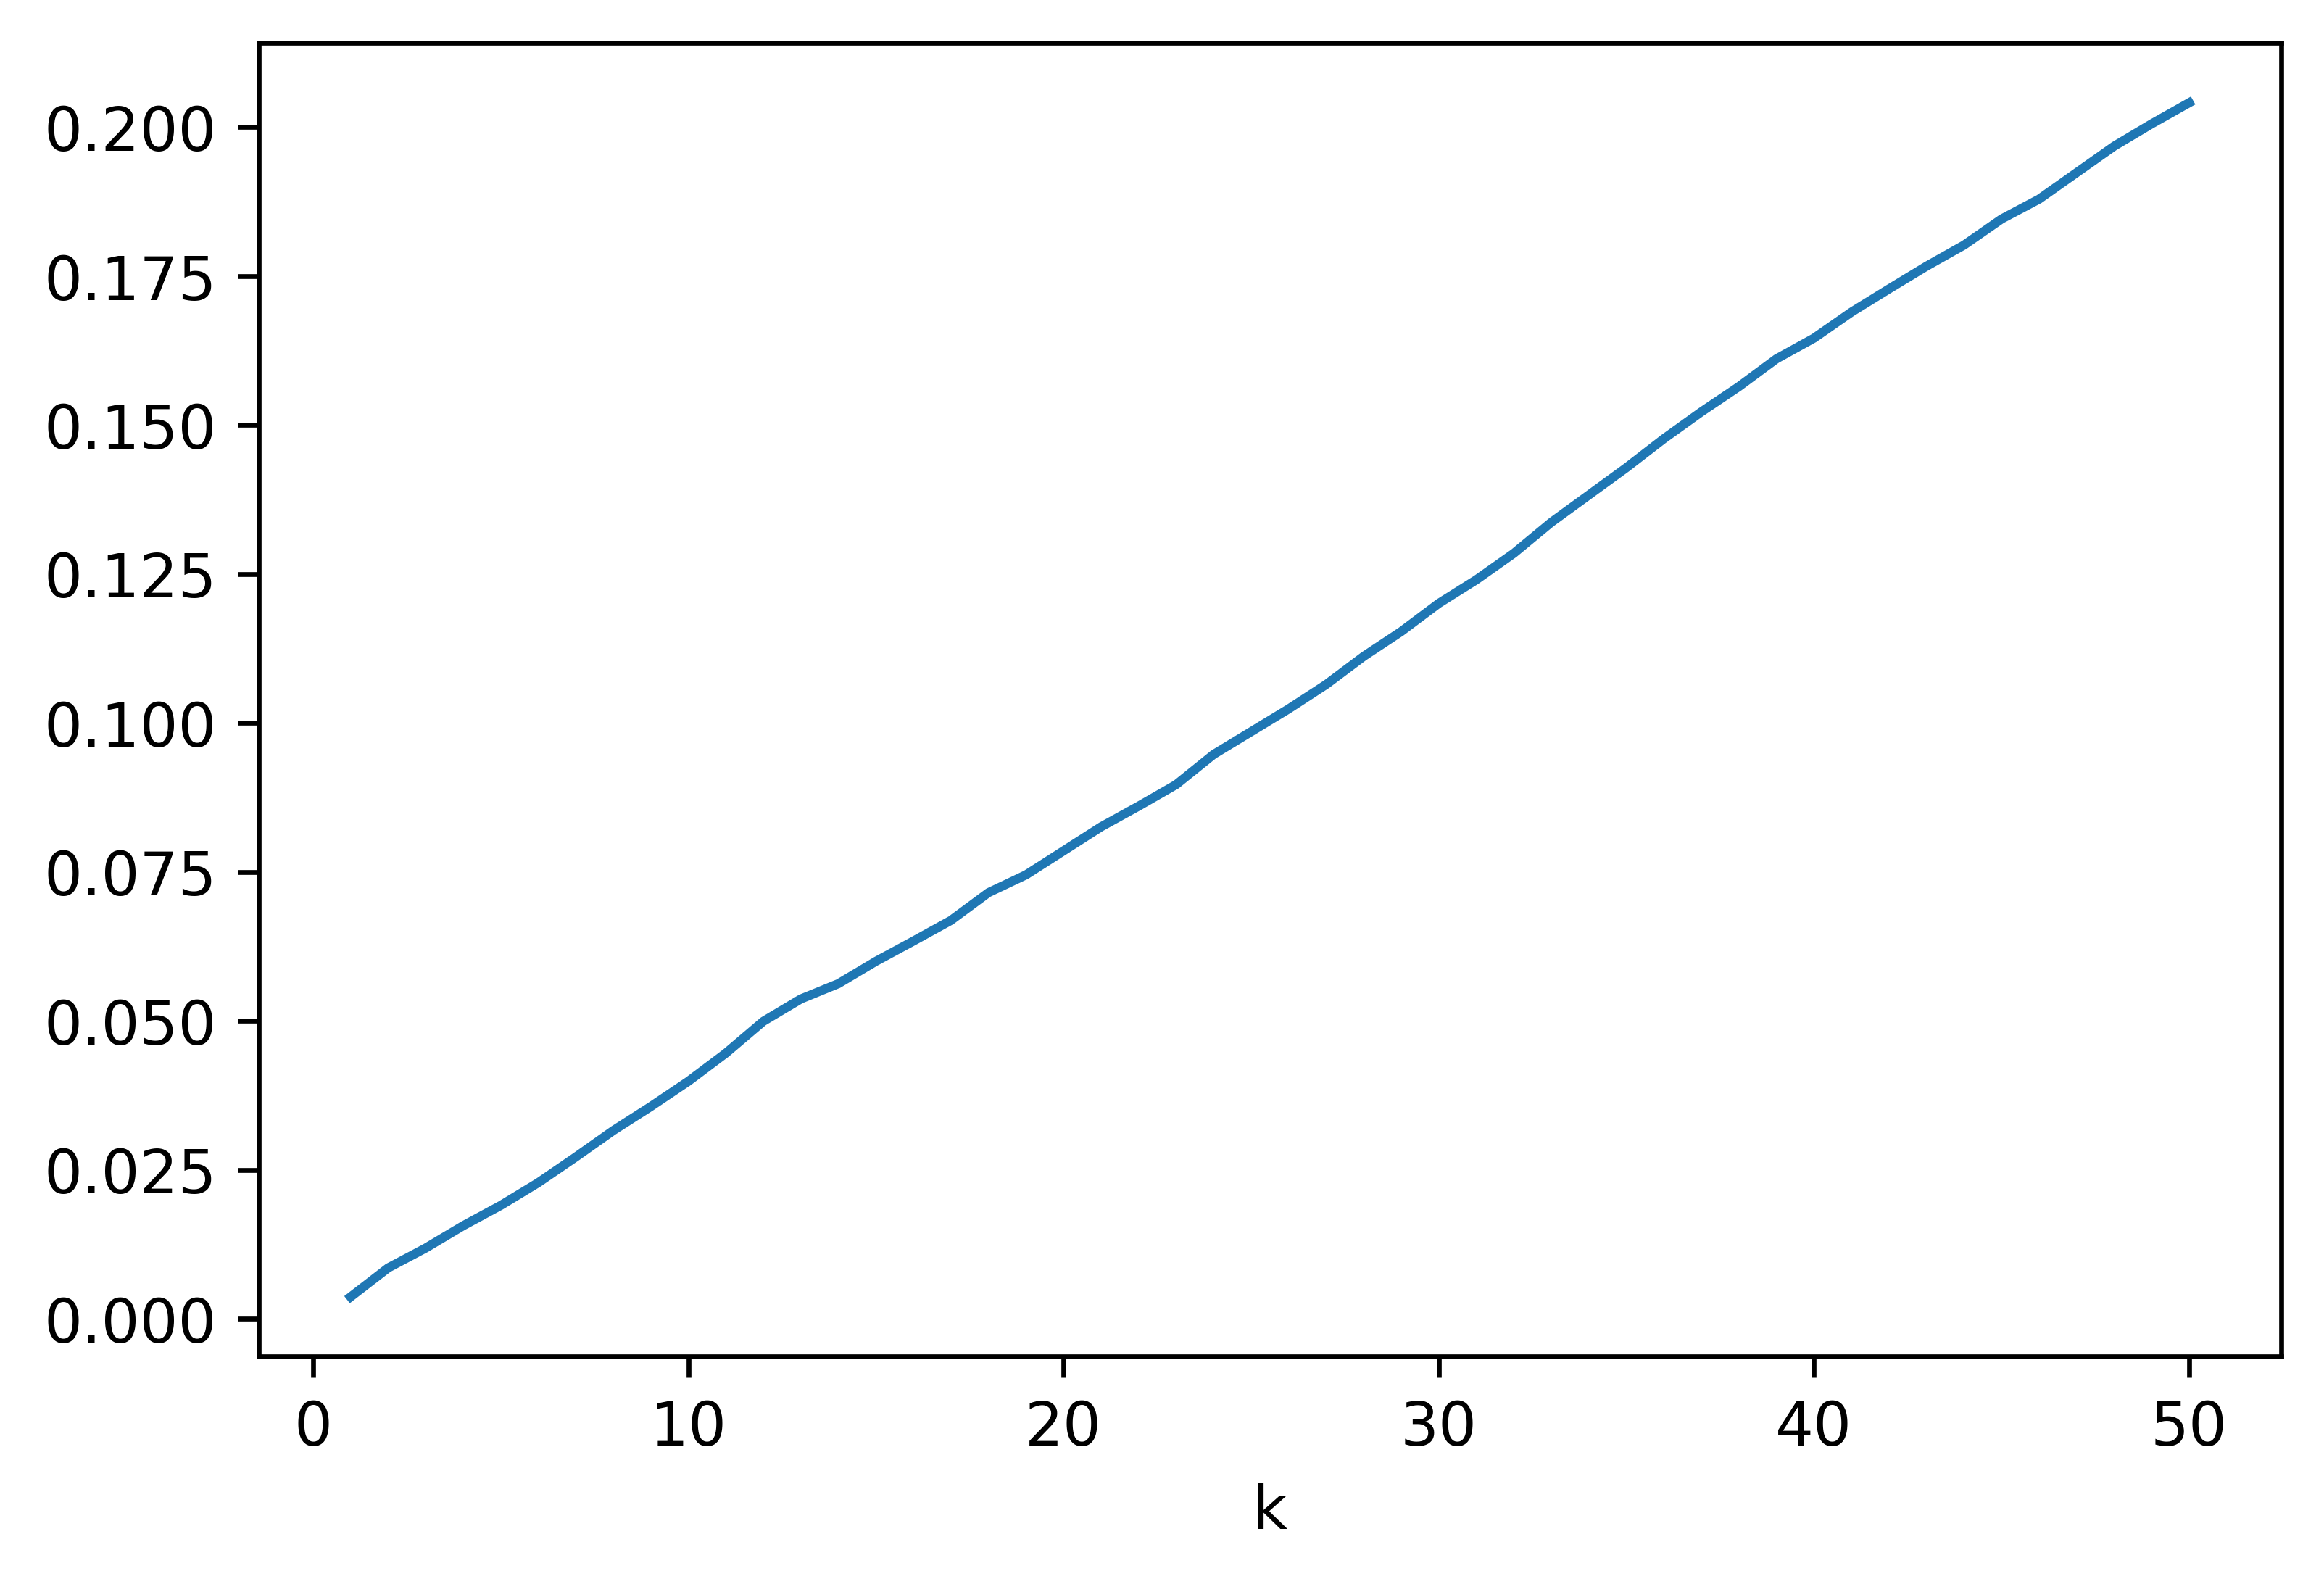

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [288]:
morph_embs_random_knn_acc_results.groupby("k").mean().knn_acc.plot()

---

#### NTK model

We will assess how well the NTK model performs on the prediction task.

In [29]:
model_type = "ntk"
model_params_dicts = [
    {"reg": 1},
    {"reg": 5},
    {"reg": 10},
    {"reg": 50},
    {"reg": 100},
]


use_y_train_mean_params = [False, True]
n_neighbors_weights_features_params = [31]
n_weight_encodings_params = [2, 5, 10, 20]
append_neighbor_embs_params = [None, "images", "genes"]
neighbor_weight_encoding_params = ["positional", "gauss"]
rff_sigma_params = [1, 5, 10]

<IPython.core.display.Javascript object>

In [33]:
morph_embs_gs_ntk_knn_acc_results = run_jump_gridsearch_knn_accuracy(
    pert_embs=morph_embs,
    reg_embs=reg_embs,
    train_targets=list(train_targets),
    test_targets=list(test_targets),
    model_type=model_type,
    model_params_dicts=model_params_dicts,
    use_y_train_mean_params=use_y_train_mean_params,
    n_neighbors_weights_features_params=n_neighbors_weights_features_params,
    n_weight_encodings_params=n_weight_encodings_params,
    append_neighbor_embs_params=append_neighbor_embs_params,
    neighbor_weight_encoding_params=neighbor_weight_encoding_params,
    rff_sigma_params=rff_sigma_params,
    save_output_file="../../../../data/experiments/translation_results/jump/jump_morph_embs_gs_knn_results.pkl",
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-14-4475fae297a2>:57: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['model', 'pos_encoding_type', 'append_neighbor_embs'], dtype='object')]

  all_knn_acc_results.to_hdf(save_output_file, key="data")


<IPython.core.display.Javascript object>

In [281]:
output_best_model_config_ids(
    results=morph_embs_gs_ntk_knn_acc_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=21,
)

<ipython-input-15-d52defac4be7>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = results.groupby(config_id_col).mean()


,config_id,metric,value
12,632,20nn_auc,0.036706
17,415,20nn_auc,0.036706
25,632,50nn_auc,0.093410
40,415,50nn_auc,0.093273


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

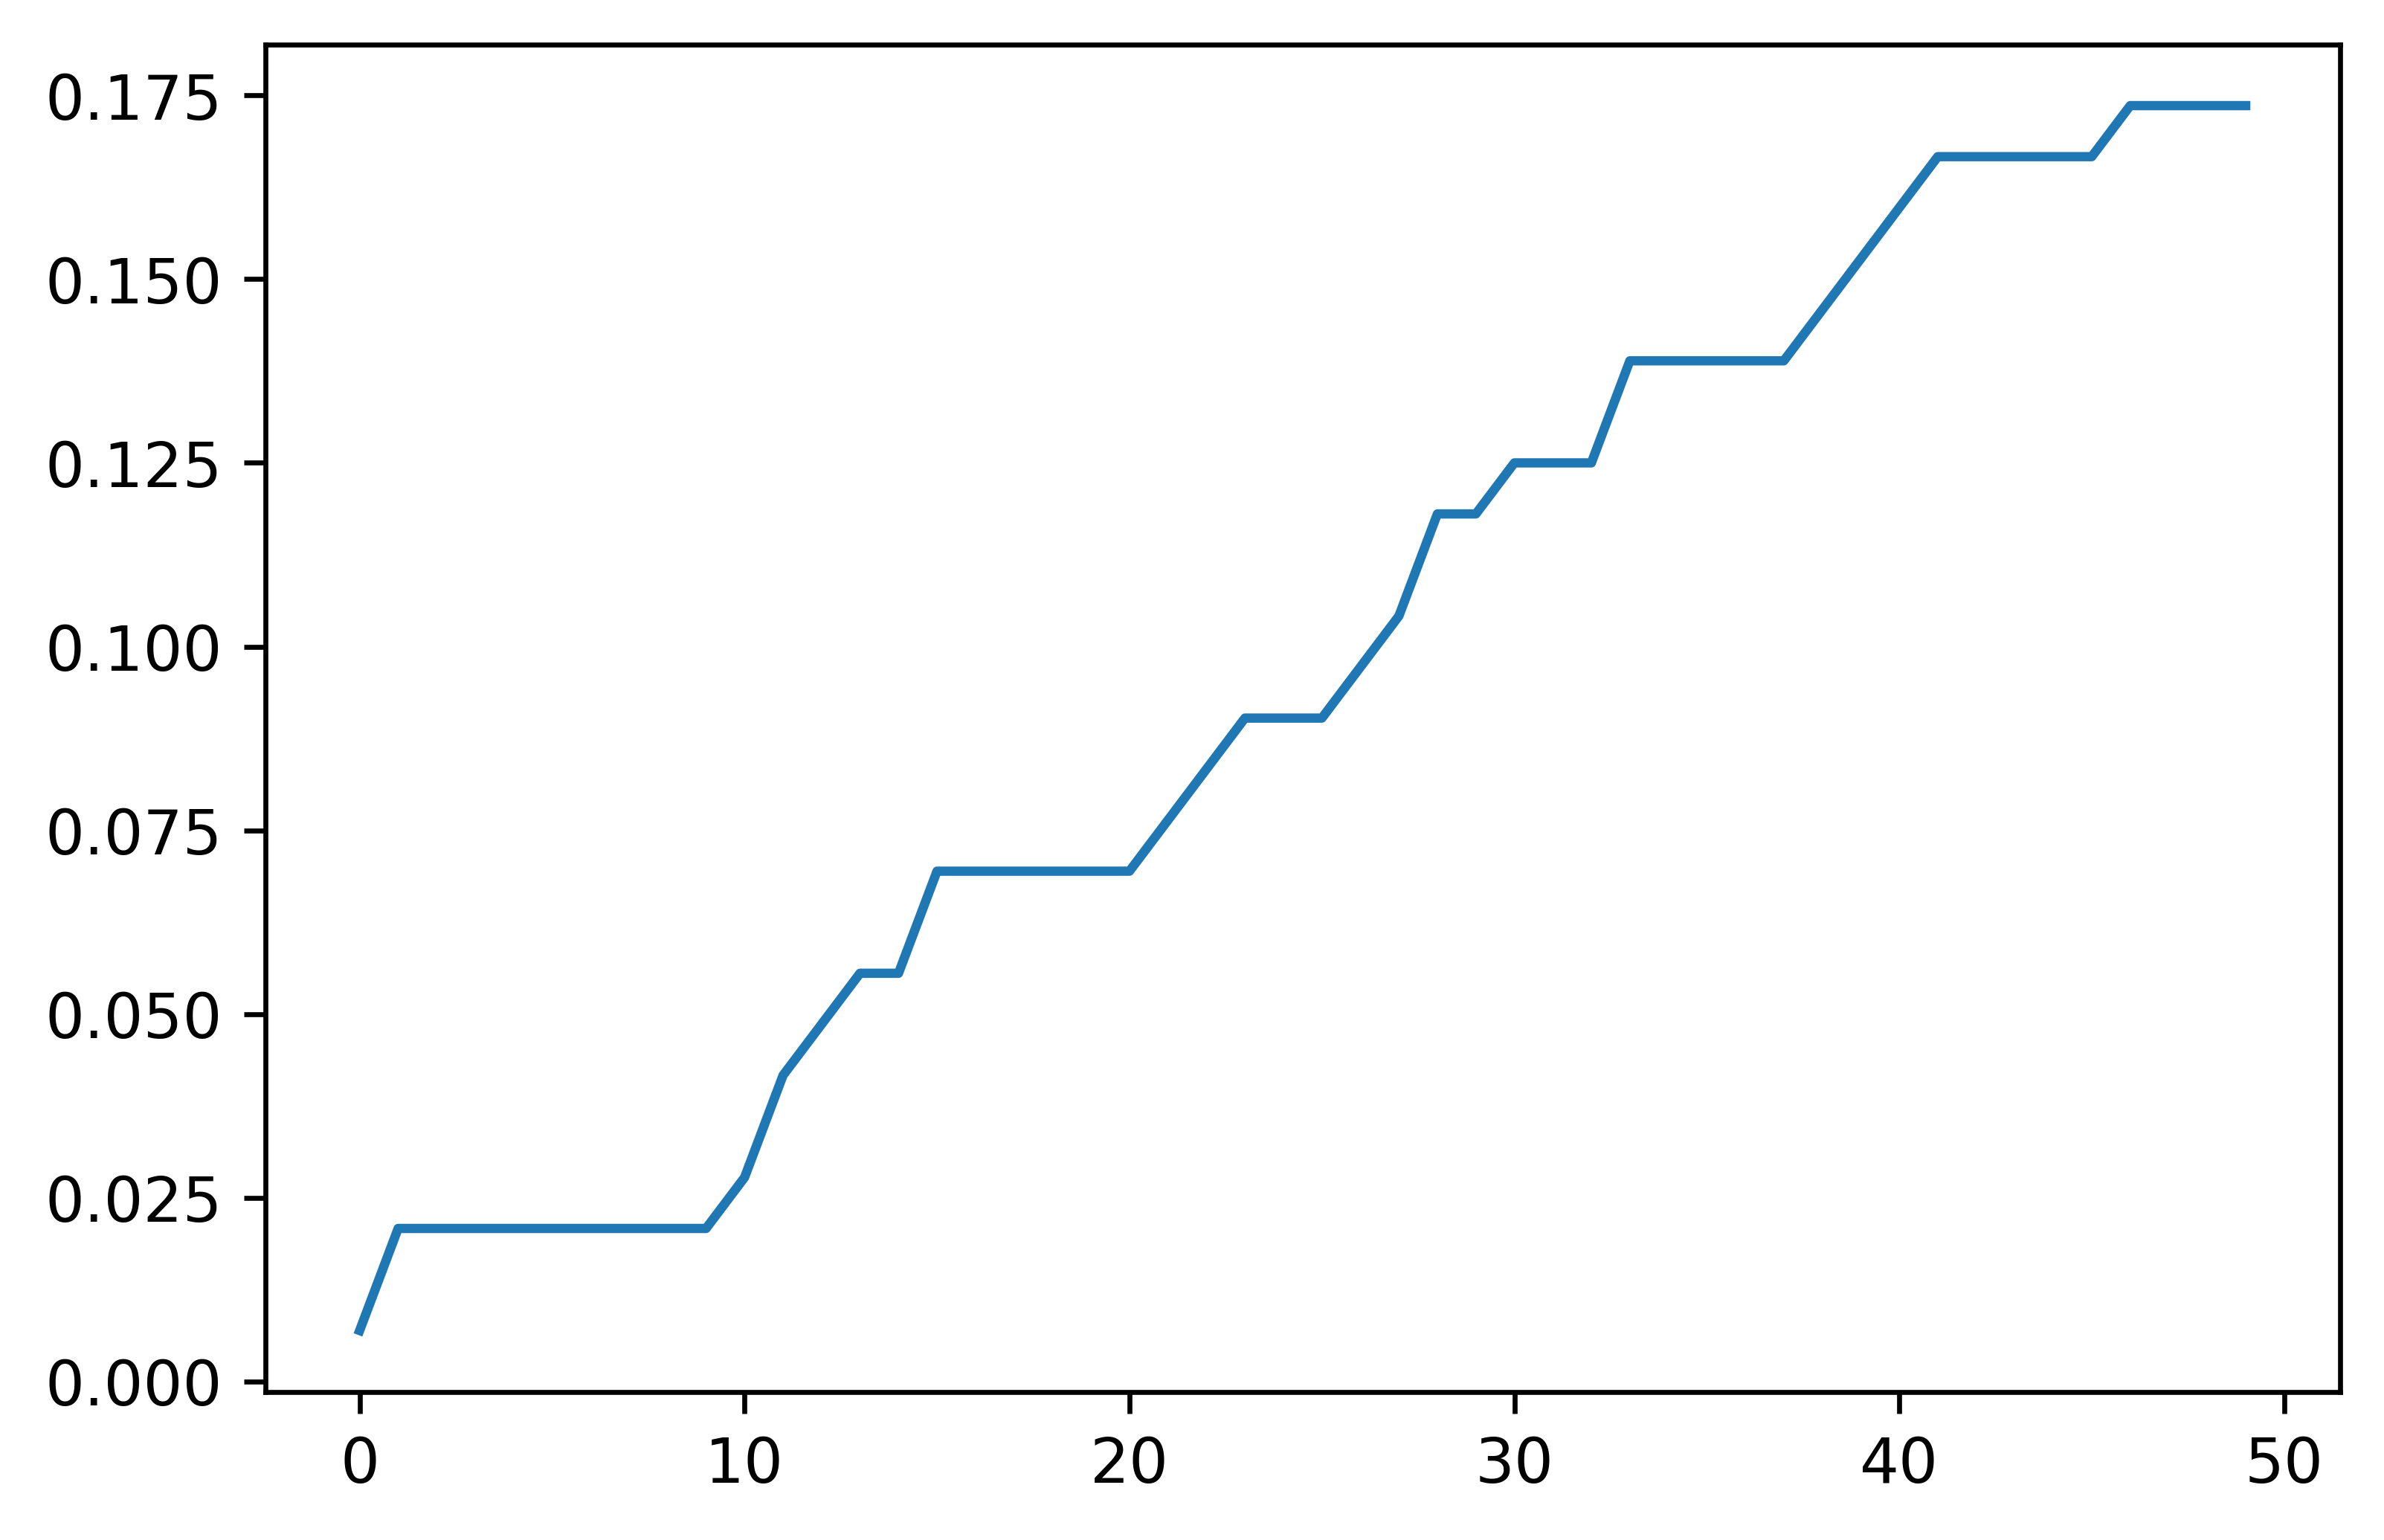

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [290]:
best_morph_embs_ntk_knn_acc_results = morph_embs_gs_ntk_knn_acc_results.loc[
    morph_embs_gs_ntk_knn_acc_results.config_id == 632
]
best_morph_embs_ntk_knn_acc_results.knn_acc.plot()

---
### Image-based gene embeddings

In [44]:
img_embs_gs_ntk_knn_acc_results = run_jump_gridsearch_knn_accuracy(
    pert_embs=img_embs,
    reg_embs=reg_embs,
    train_targets=list(train_targets),
    test_targets=list(test_targets),
    model_type=model_type,
    model_params_dicts=model_params_dicts,
    use_y_train_mean_params=use_y_train_mean_params,
    n_neighbors_weights_features_params=n_neighbors_weights_features_params,
    n_weight_encodings_params=n_weight_encodings_params,
    append_neighbor_embs_params=append_neighbor_embs_params,
    neighbor_weight_encoding_params=neighbor_weight_encoding_params,
    rff_sigma_params=rff_sigma_params,
    save_output_file="../../../../data/experiments/translation_results/jump/jump_img_embs_gs_knn_results.pkl",
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-14-4475fae297a2>:57: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['model', 'pos_encoding_type', 'append_neighbor_embs'], dtype='object')]

  all_knn_acc_results.to_hdf(save_output_file, key="data")


<IPython.core.display.Javascript object>

In [293]:
output_best_model_config_ids(
    results=img_embs_gs_ntk_knn_acc_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=1,
)

<ipython-input-15-d52defac4be7>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = results.groupby(config_id_col).mean()


,config_id,metric,value
0,345,20nn_auc,0.045304
1,345,50nn_auc,0.099129


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

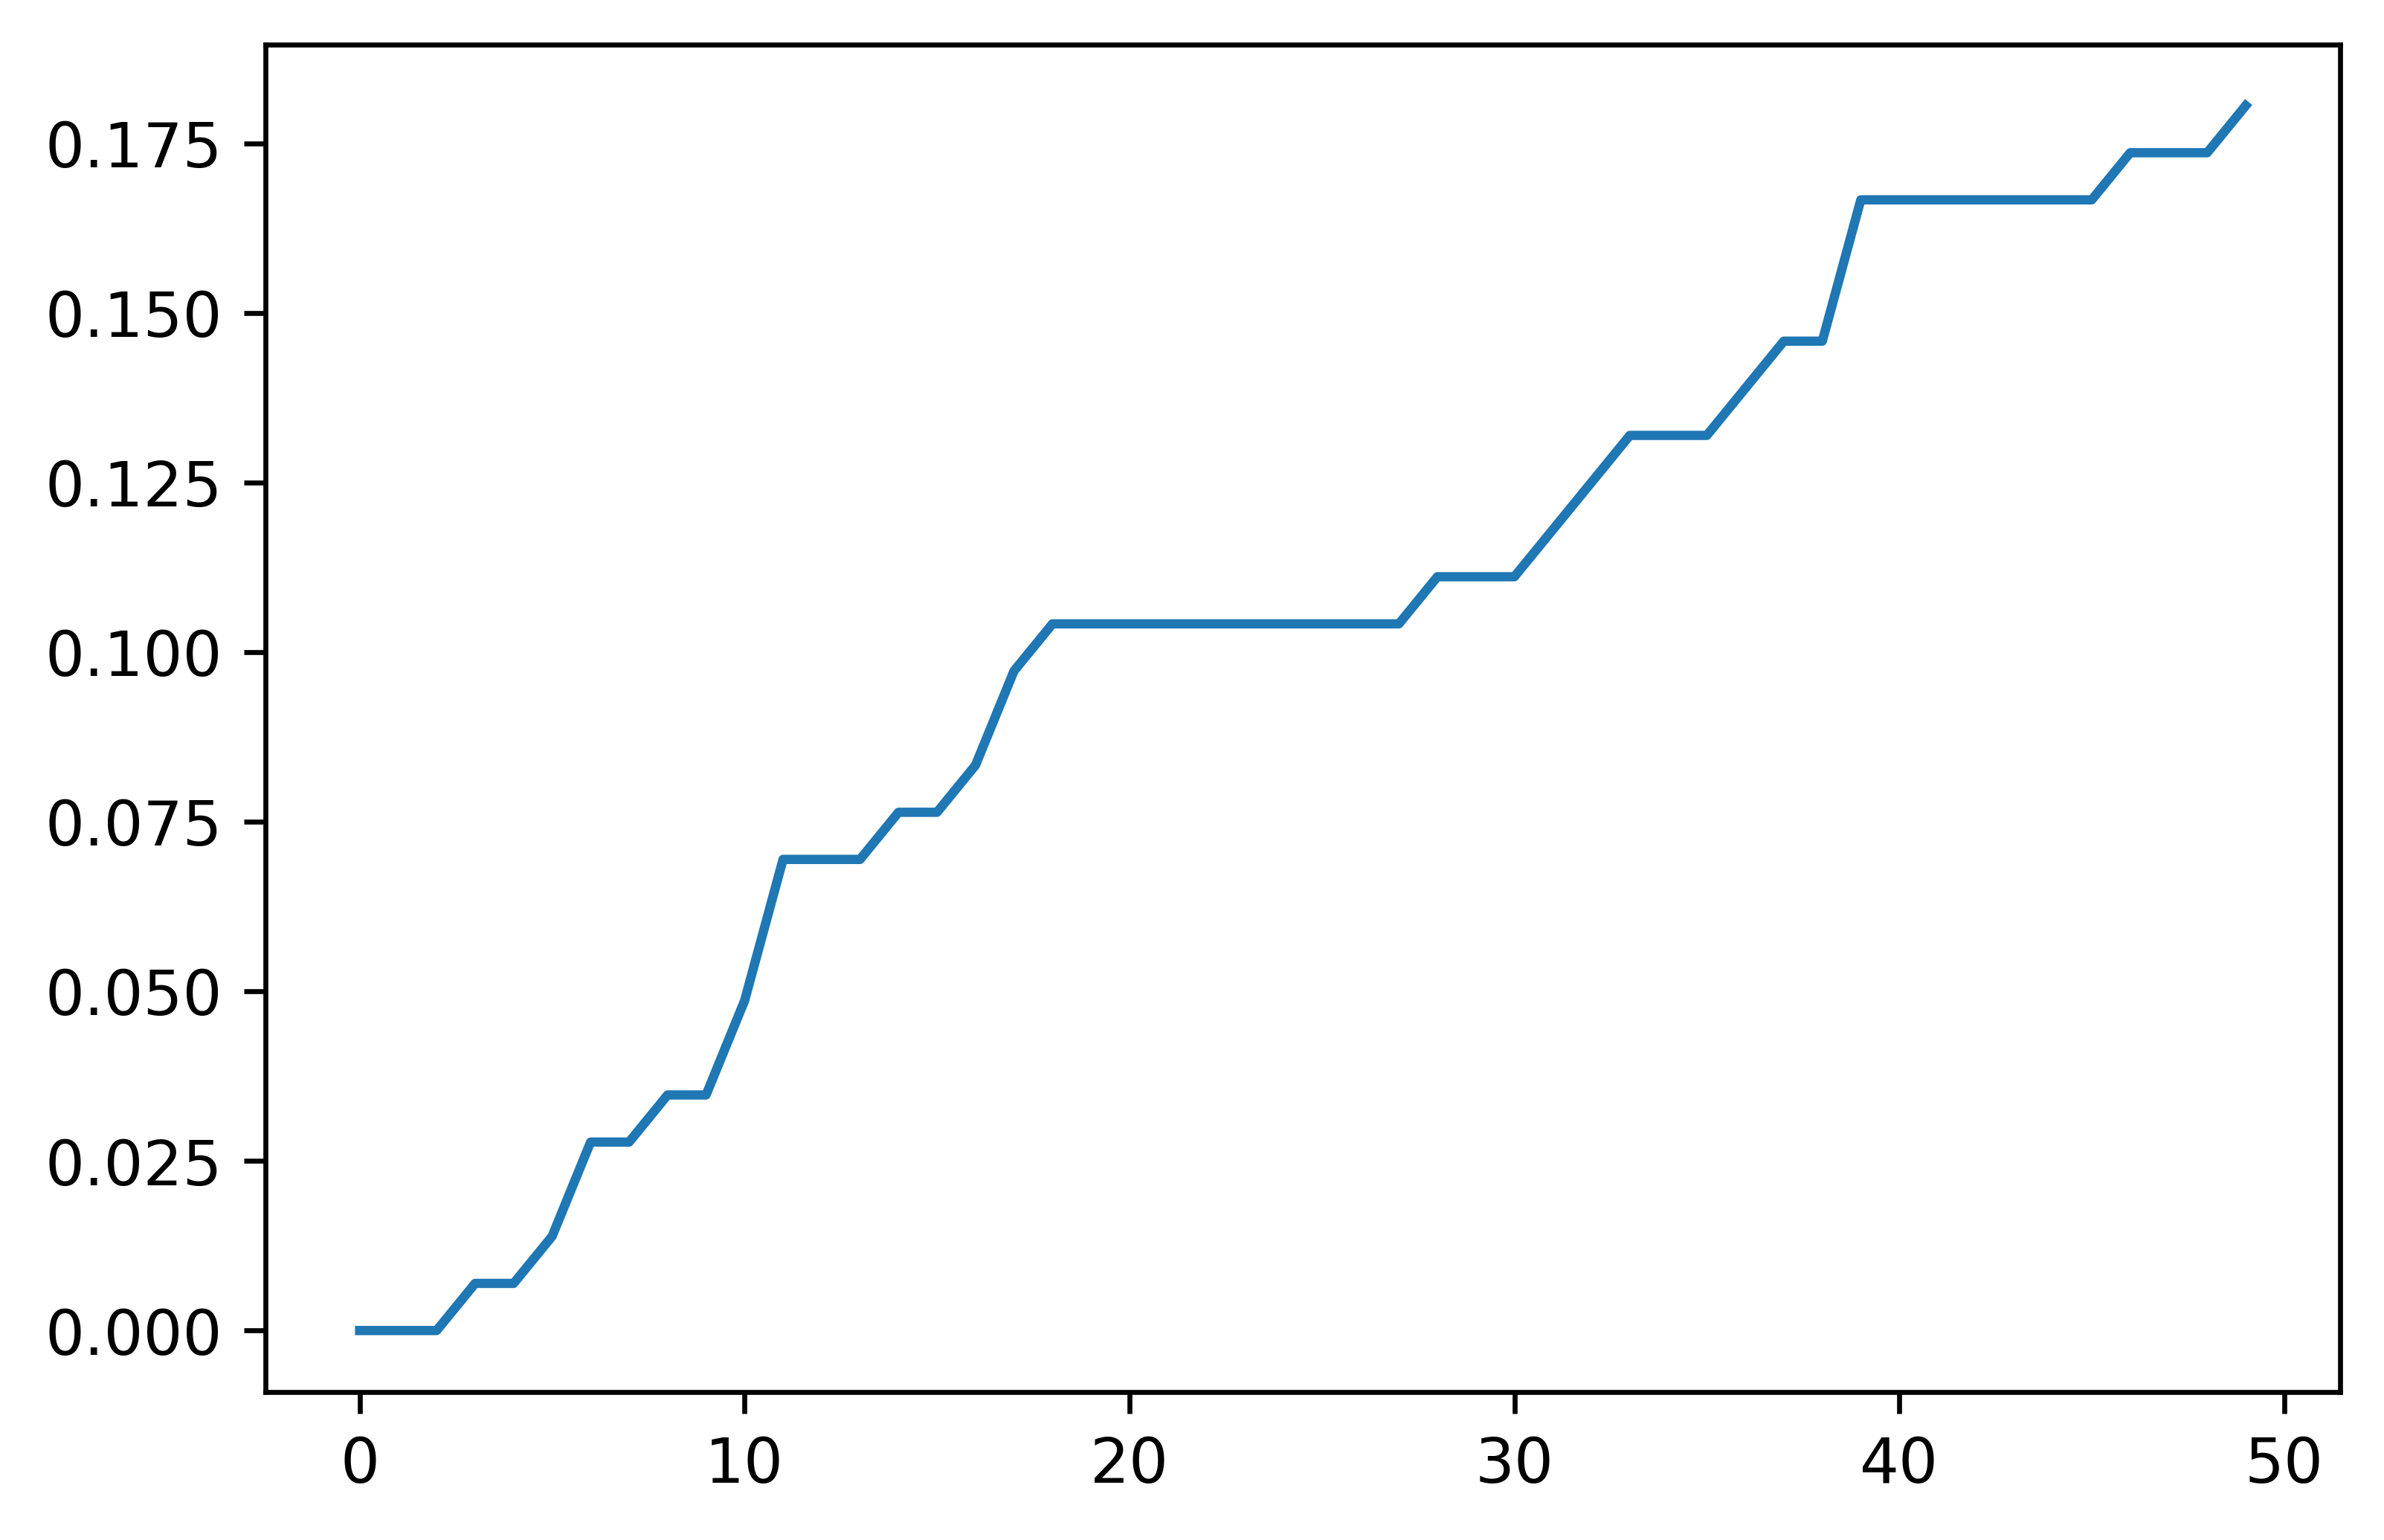

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [294]:
best_img_embs_ntk_knn_acc_results = img_embs_gs_ntk_knn_acc_results.loc[
    img_embs_gs_ntk_knn_acc_results.config_id == 345
]
best_img_embs_ntk_knn_acc_results.knn_acc.plot()

---
### Batch-centered morphological embeddings

In [45]:
morph_embs_bc_gs_ntk_knn_acc_results = run_jump_gridsearch_knn_accuracy(
    pert_embs=morph_embs_bc,
    reg_embs=reg_embs,
    train_targets=list(train_targets),
    test_targets=list(test_targets),
    model_type=model_type,
    model_params_dicts=model_params_dicts,
    use_y_train_mean_params=use_y_train_mean_params,
    n_neighbors_weights_features_params=n_neighbors_weights_features_params,
    n_weight_encodings_params=n_weight_encodings_params,
    append_neighbor_embs_params=append_neighbor_embs_params,
    neighbor_weight_encoding_params=neighbor_weight_encoding_params,
    rff_sigma_params=rff_sigma_params,
    save_output_file="../../../../data/experiments/translation_results/jump/jump_morph_embs_bc_gs_knn_results.pkl",
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-14-4475fae297a2>:57: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['model', 'pos_encoding_type', 'append_neighbor_embs'], dtype='object')]

  all_knn_acc_results.to_hdf(save_output_file, key="data")


<IPython.core.display.Javascript object>

In [298]:
output_best_model_config_ids(
    results=morph_embs_bc_gs_ntk_knn_acc_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=15,
)

<ipython-input-15-d52defac4be7>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = results.groupby(config_id_col).mean()


,config_id,metric,value
11,464,20nn_auc,0.038360
21,464,50nn_auc,0.096678


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

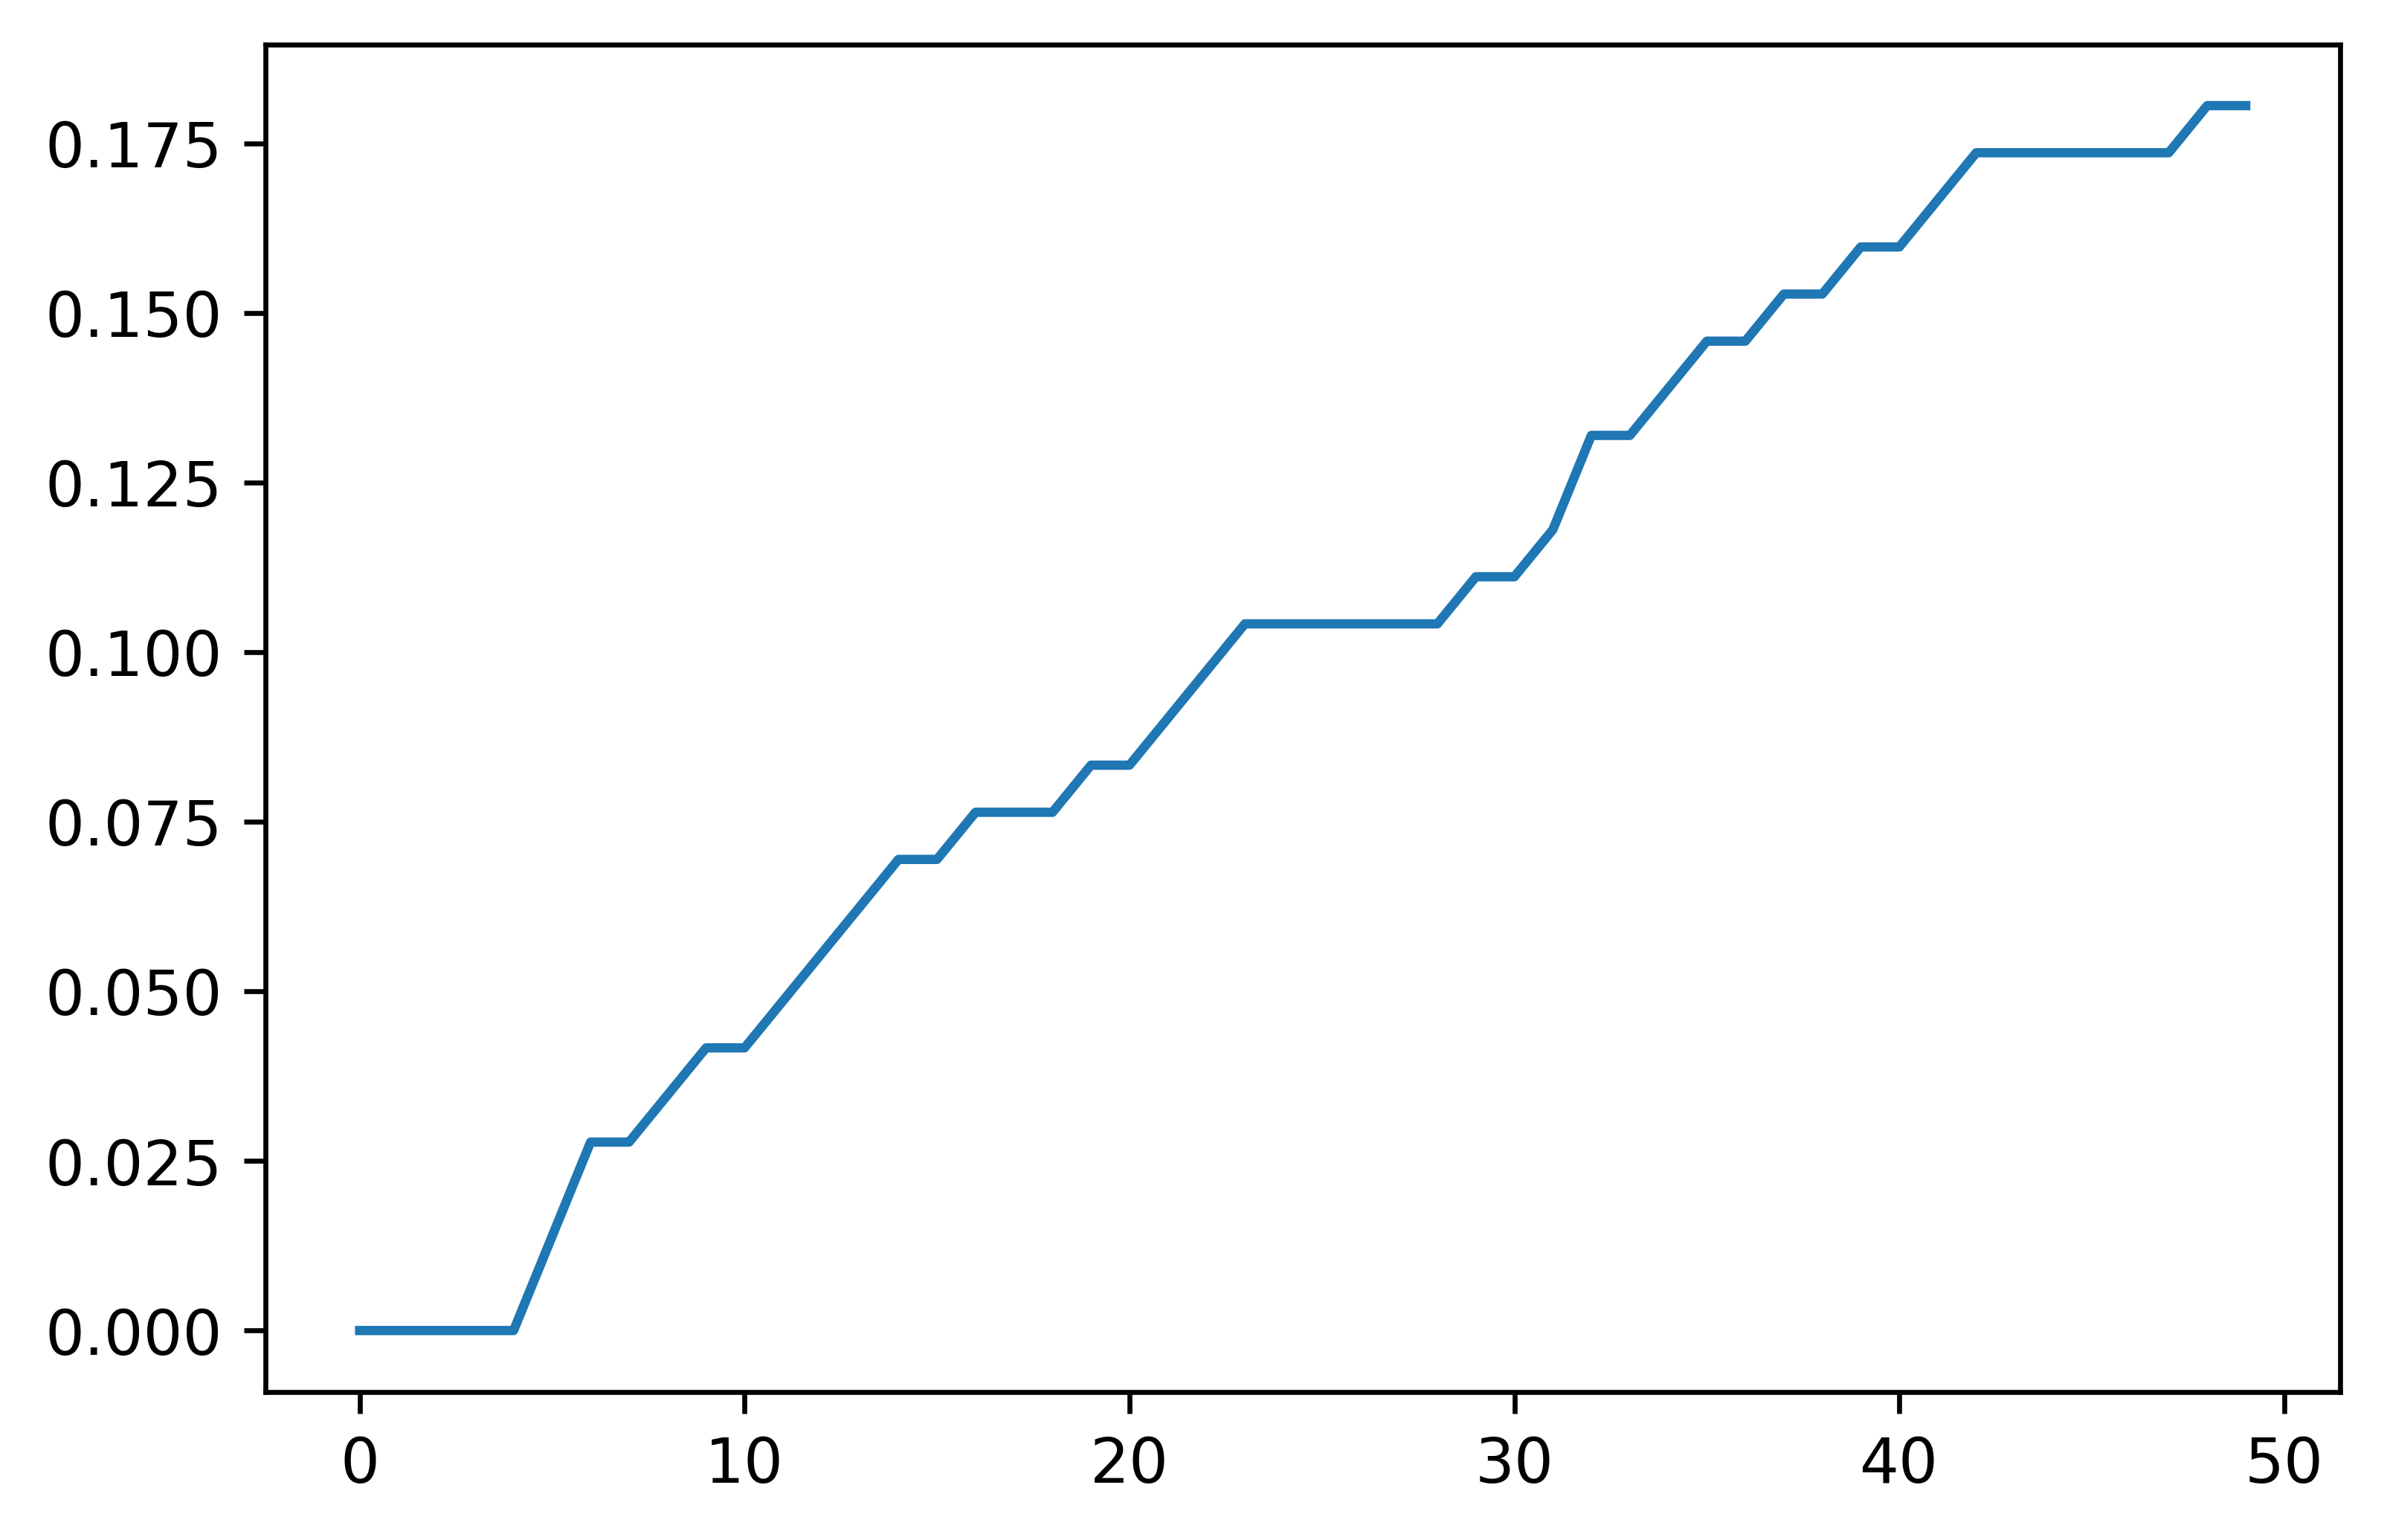

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [299]:
best_morph_embs_bc_ntk_knn_acc_results = morph_embs_bc_gs_ntk_knn_acc_results.loc[
    morph_embs_bc_gs_ntk_knn_acc_results.config_id == 464
]
best_morph_embs_bc_ntk_knn_acc_results.knn_acc.plot()

In [264]:
scaled_pert_embs = pd.DataFrame(
    StandardScaler().fit_transform(img_embs),
    index=img_embs.index,
    columns=img_embs.columns,
)

tmp = get_jump_knn_acc_for_model(
    pert_embs=morph_embs_bc,
    reg_embs=reg_embs,
    train_targets=list(train_targets - {"JUN"}),
    test_targets=["JUN"],
    model_type="linear_regression",
)

linear_regression JUN [237] ['BRAF' 'PAK2' 'RAF1' 'KRT18' 'ALOX5']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [270]:
pert_nn = NearestNeighbors(n_neighbors=len(morph_embs_bc))
pert_samples = np.array(list(morph_embs_bc.index))
pert_nn.fit(np.array(morph_embs_bc))
pert_samples[
    pert_nn.kneighbors(np.array(morph_embs_bc.loc["CASP8"]).reshape(1, -1))[1][0]
][:20]

array(['CASP8', 'BCL2L11', 'CCNA2', 'SDC2', 'PRKACA', 'KIF2C', 'MSH2',
       'THY1', 'ERG', 'BAX', 'SKP2', 'TIMP1', 'SDC1', 'LRP1', 'RHOA',
       'TCF4', 'CLU', 'PRAME', 'RARA', 'IGF2'], dtype='<U8')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [266]:
reg_nn = NearestNeighbors(n_neighbors=len(reg_embs))
reg_samples = np.array(list(reg_embs.index))
reg_nn.fit(np.array(reg_embs))
reg_samples[reg_nn.kneighbors(np.array(reg_embs.loc["BRAF"]).reshape(1, -1))[1][0]][:20]

array(['BRAF', 'PAK2', 'RAF1', 'KRT18', 'PRKCE', 'YES1', 'HRAS', 'ALOX5',
       'MYL2', 'KRT15', 'PIK3R2', 'HSP90AB1', 'CDK14', 'PDGFRB', 'TNNT1',
       'HK2', 'AXL', 'DSP', 'FKBP4', 'FGFR3'], dtype='<U8')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

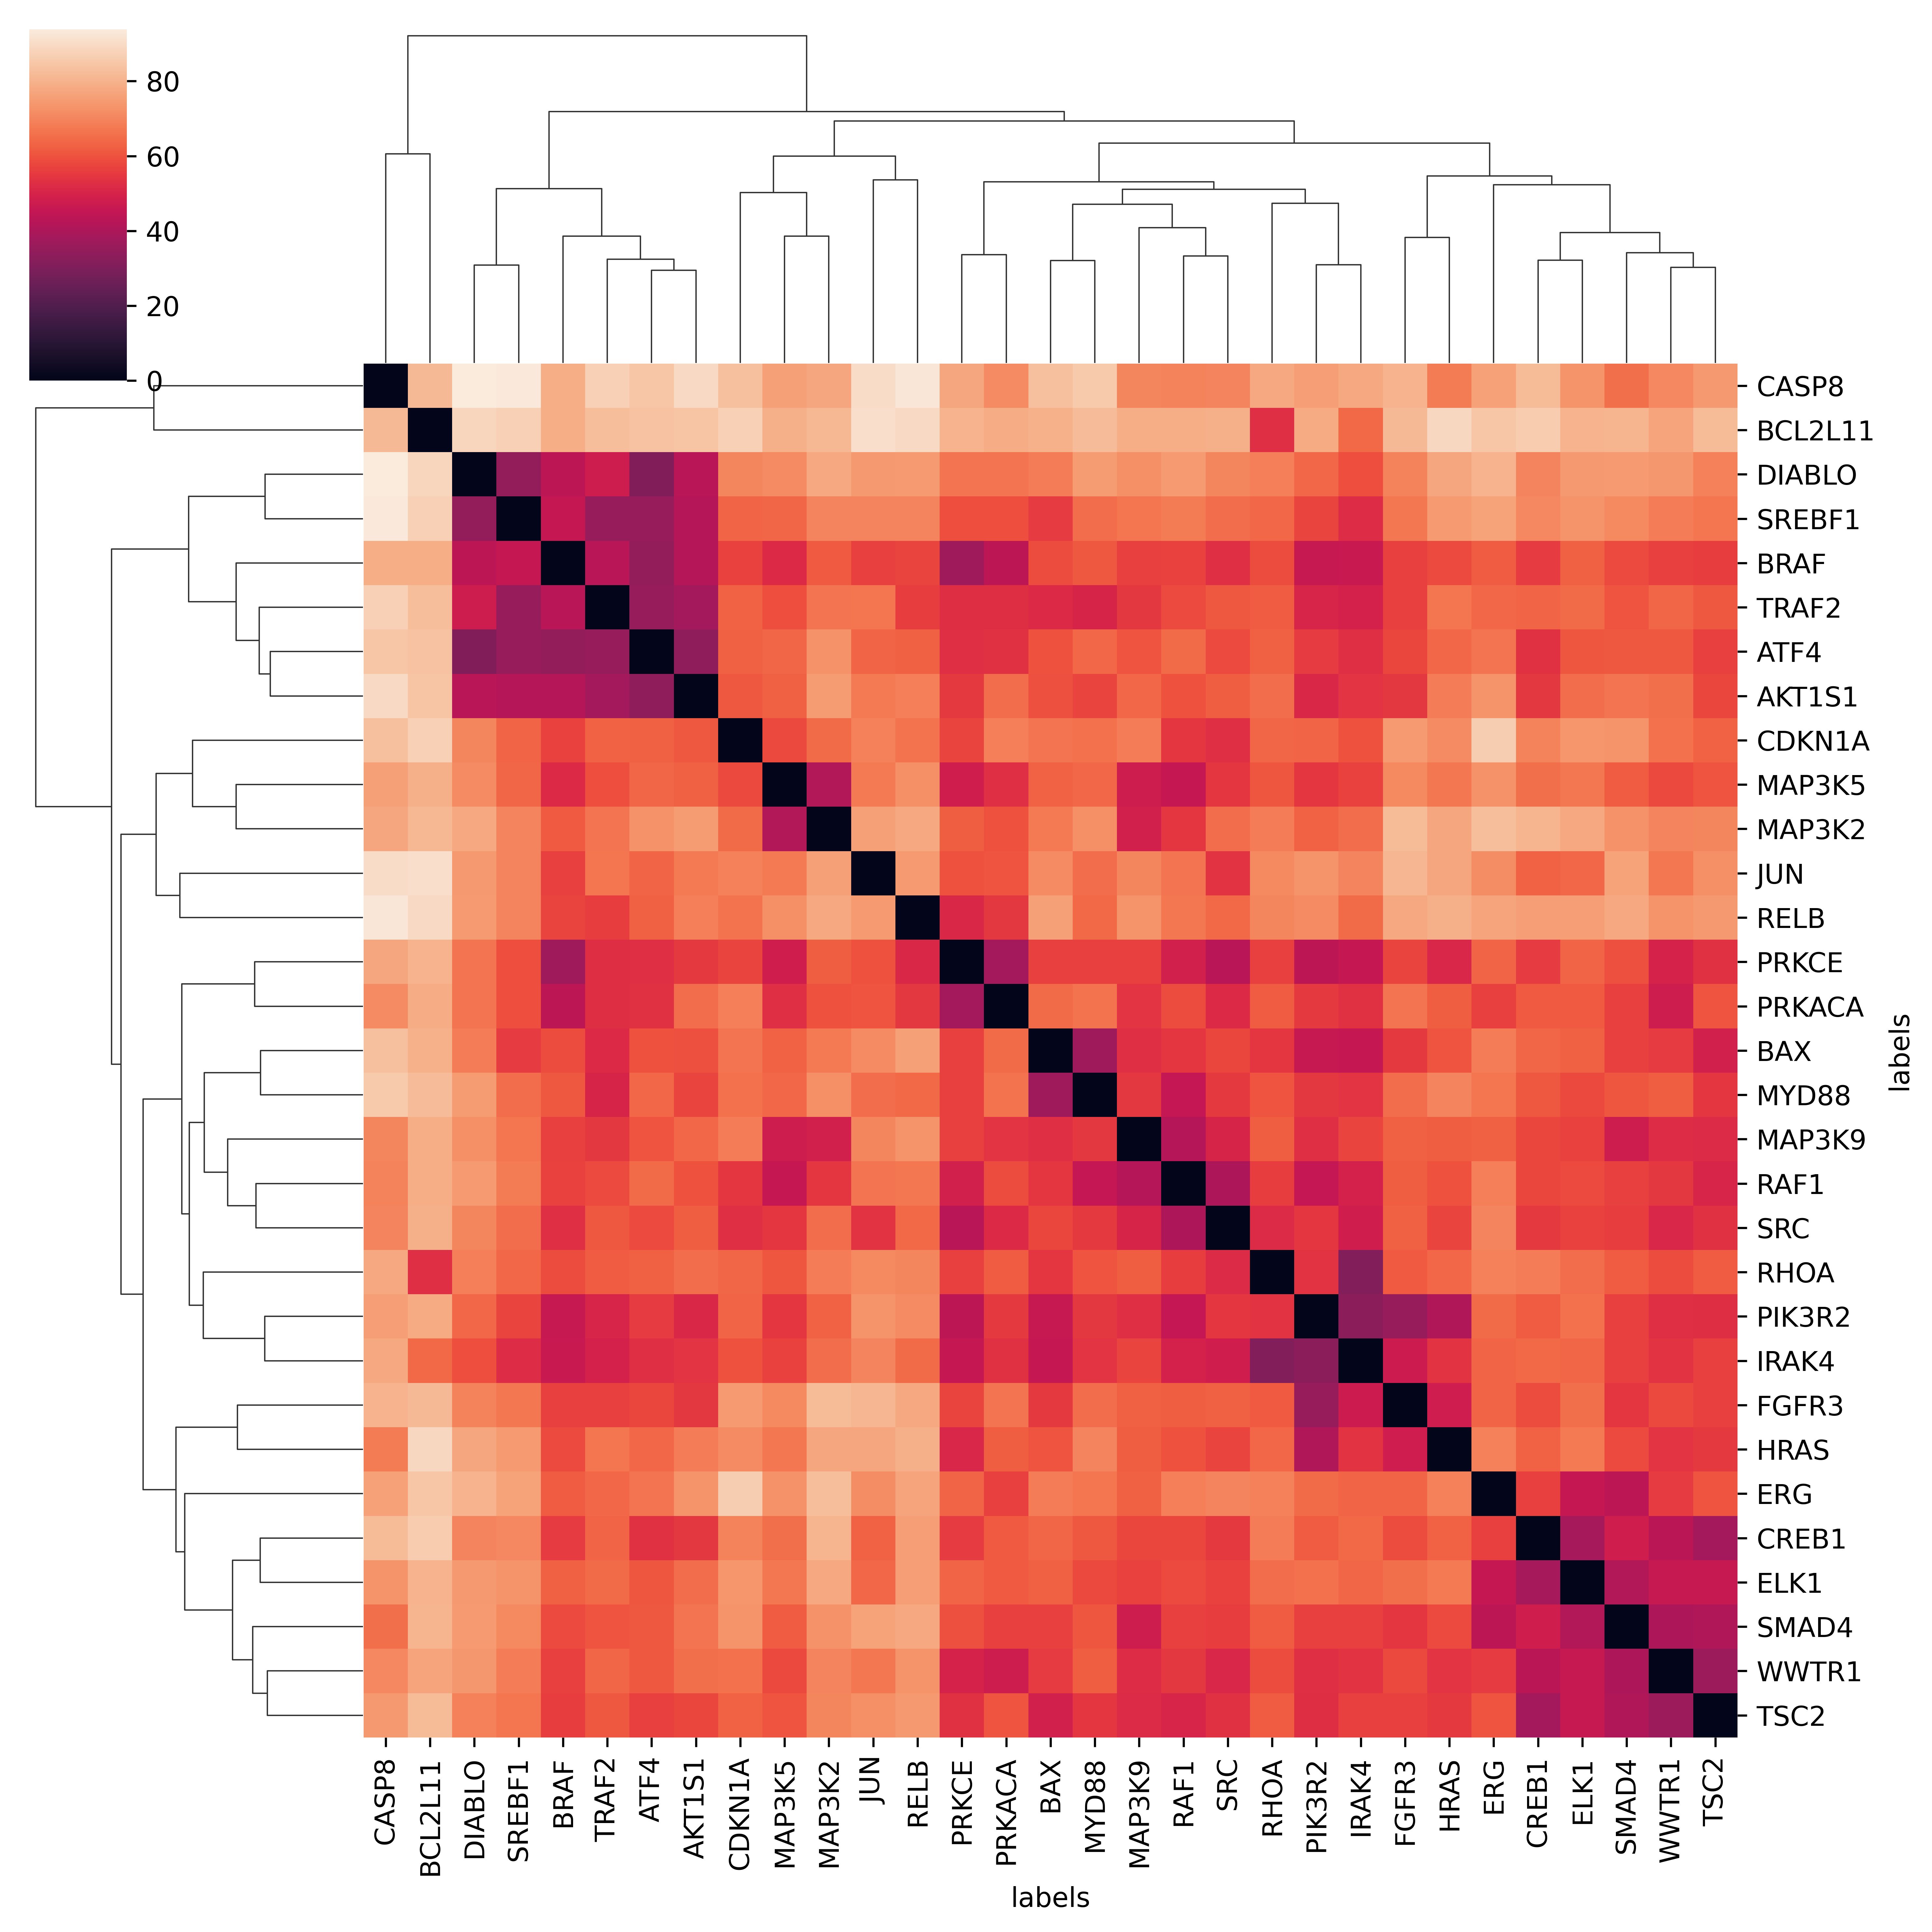

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [252]:
from scipy.spatial.distance import squareform, pdist

dist = scaled_pert_embs.loc[list(train_targets)]
dist = pd.DataFrame(squareform(pdist(dist)), index=dist.index, columns=dist.index)
sns.clustermap(dist, method="complete")

In [220]:
tmp.knn_acc.iloc[[0, 4, 9, 19, 49]]

0     0.006944
4     0.027778
9     0.041667
19    0.069444
49    0.173611
Name: knn_acc, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
print(sorted(list(train_targets)))

['AKT1S1', 'ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CDKN1A', 'CREB1', 'DIABLO', 'ELK1', 'ERG', 'FGFR3', 'HRAS', 'IRAK4', 'JUN', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMAD4', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
### Batch-centered image-based gene embeddings

In [46]:
img_embs_bc_gs_ntk_knn_acc_results = run_jump_gridsearch_knn_accuracy(
    pert_embs=img_embs_bc,
    reg_embs=reg_embs,
    train_targets=list(train_targets),
    test_targets=list(test_targets),
    model_type=model_type,
    model_params_dicts=model_params_dicts,
    use_y_train_mean_params=use_y_train_mean_params,
    n_neighbors_weights_features_params=n_neighbors_weights_features_params,
    n_weight_encodings_params=n_weight_encodings_params,
    append_neighbor_embs_params=append_neighbor_embs_params,
    neighbor_weight_encoding_params=neighbor_weight_encoding_params,
    rff_sigma_params=rff_sigma_params,
    save_output_file="../../../../data/experiments/translation_results/jump/jump_img_embs_bc_gs_knn_results.pkl",
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-14-4475fae297a2>:57: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['model', 'pos_encoding_type', 'append_neighbor_embs'], dtype='object')]

  all_knn_acc_results.to_hdf(save_output_file, key="data")


<IPython.core.display.Javascript object>

In [306]:
output_best_model_config_ids(
    results=img_embs_bc_gs_ntk_knn_acc_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=9,
)

<ipython-input-15-d52defac4be7>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = results.groupby(config_id_col).mean()


,config_id,metric,value
8,522,20nn_auc,0.034722
12,522,50nn_auc,0.076661


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

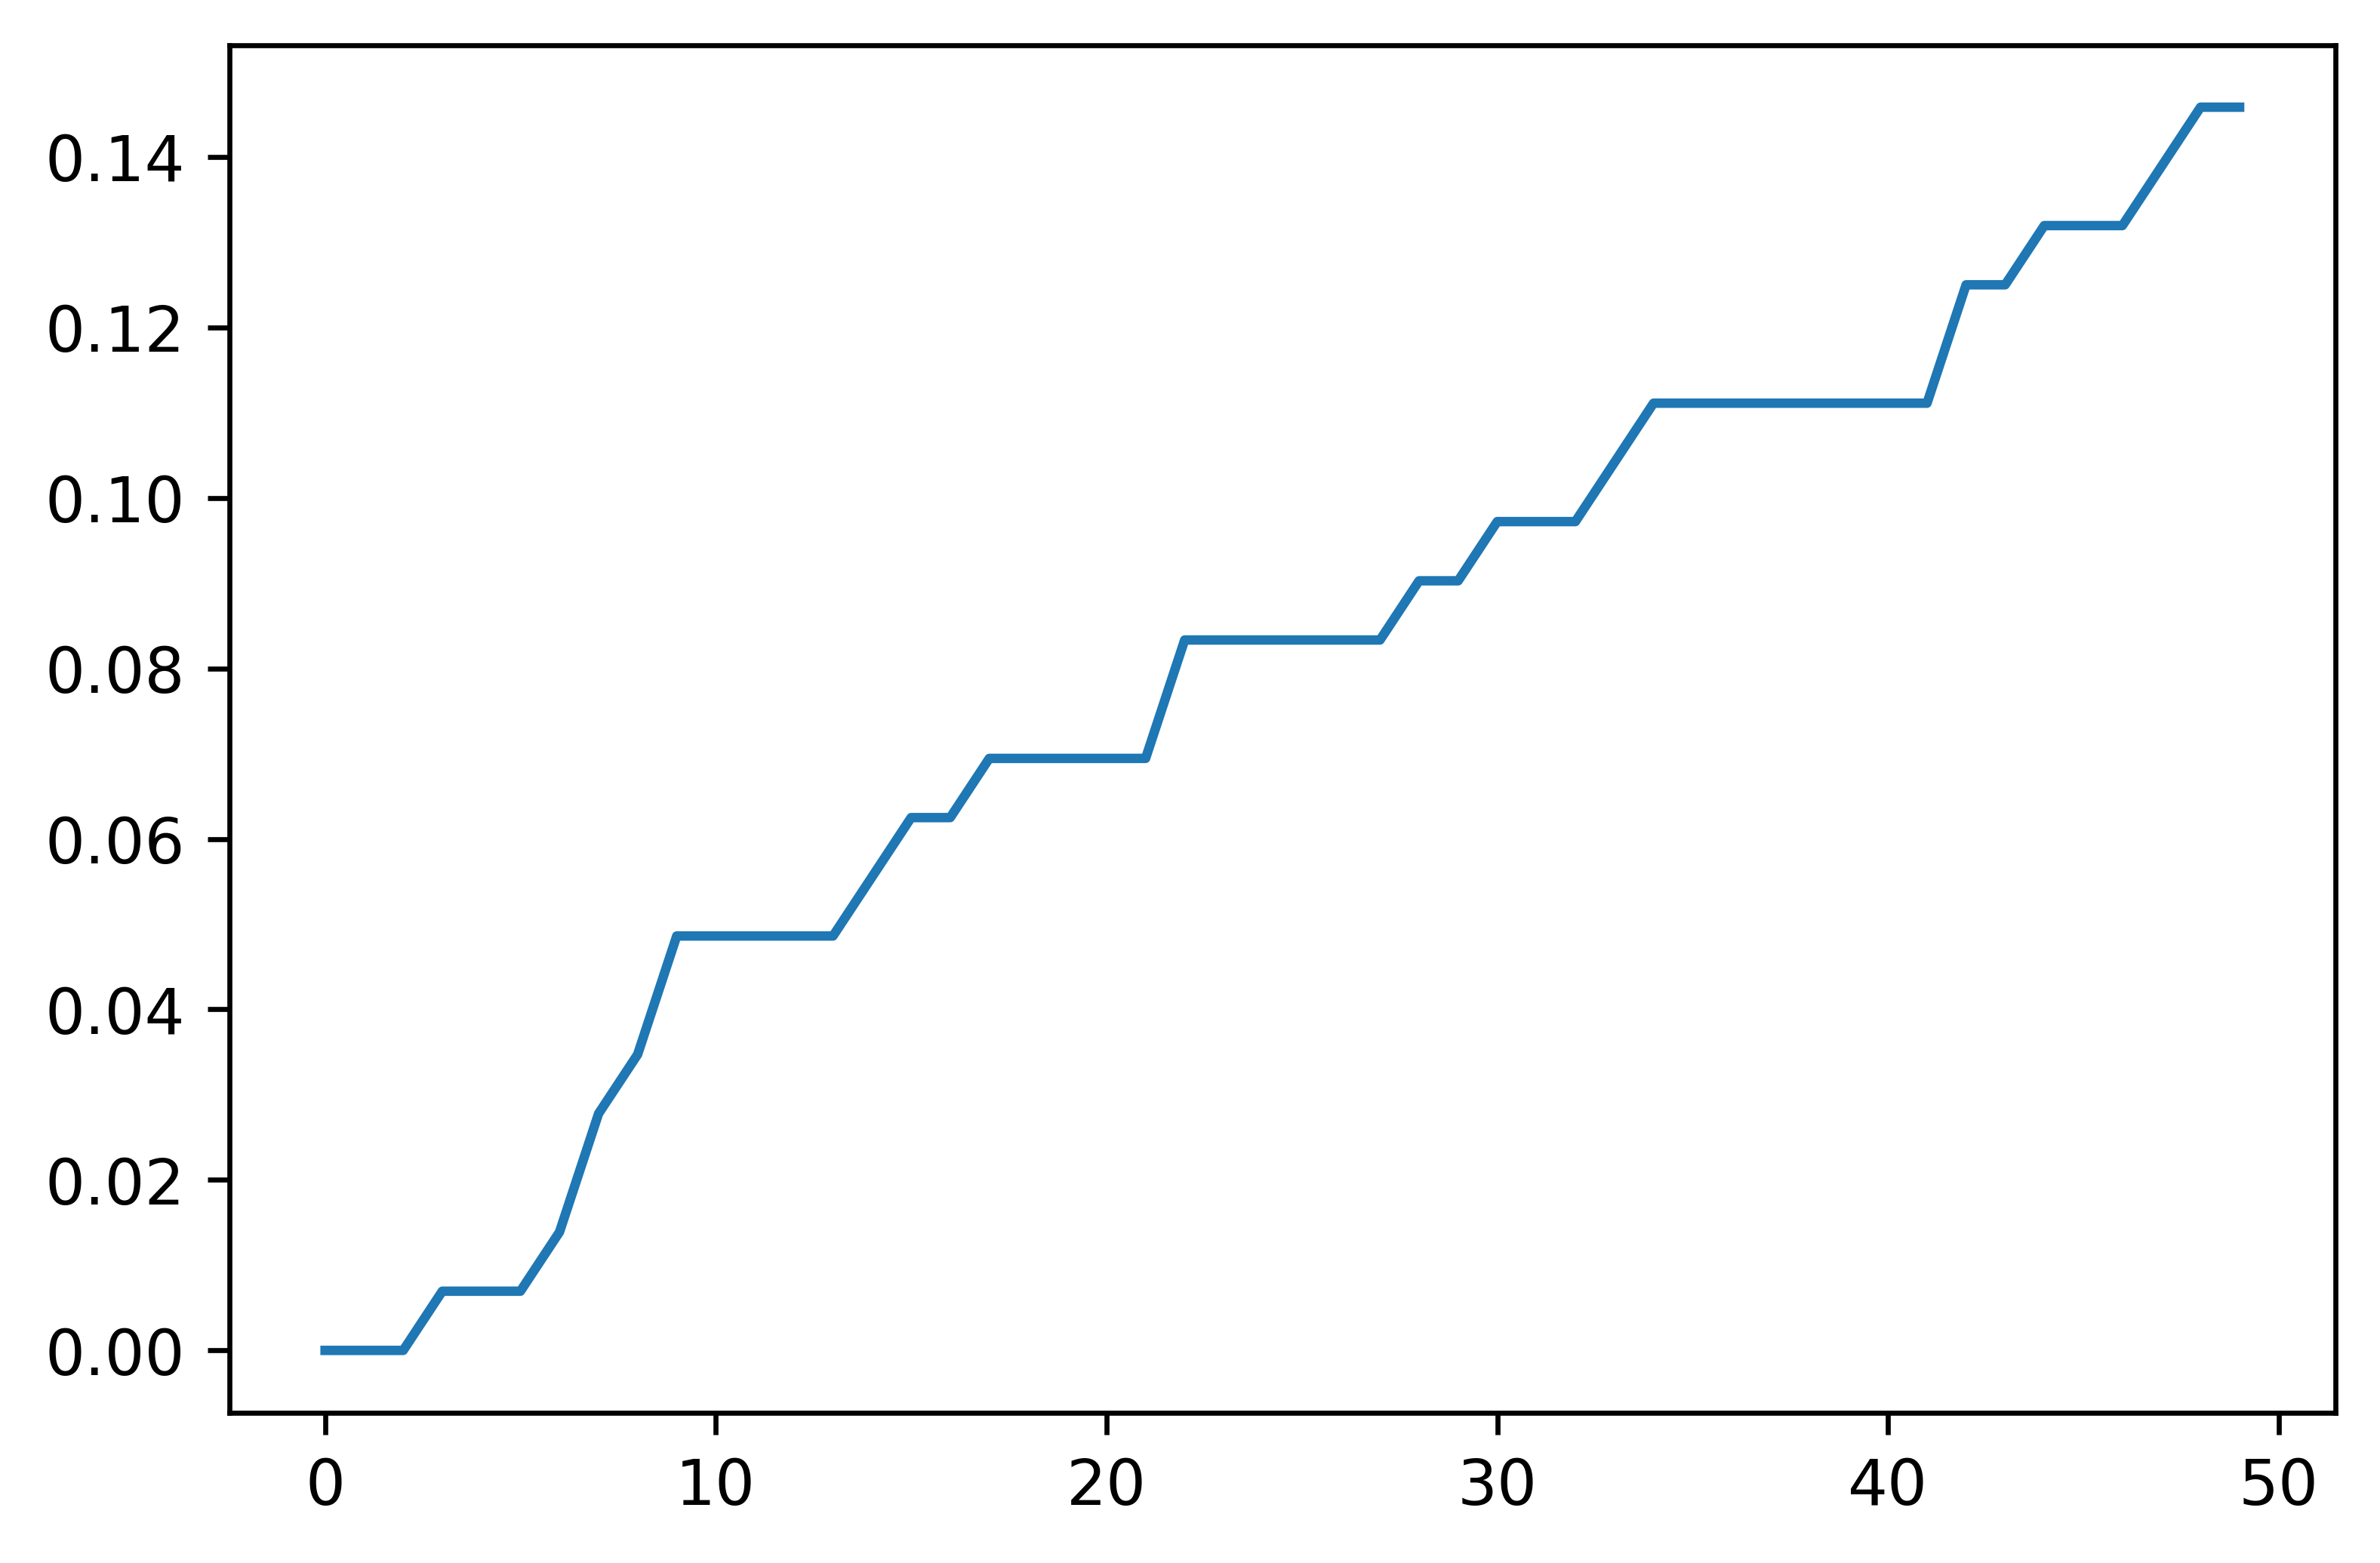

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [307]:
best_img_embs_bc_ntk_knn_acc_results = img_embs_bc_gs_ntk_knn_acc_results.loc[
    img_embs_bc_gs_ntk_knn_acc_results.config_id == 522
]
best_img_embs_bc_ntk_knn_acc_results.knn_acc.plot()

---
### INSP-adjusted morphological embeddings

In [274]:
morph_embs_insp_gs_ntk_knn_acc_results = run_jump_gridsearch_knn_accuracy(
    pert_embs=morph_embs_insp,
    reg_embs=reg_embs,
    train_targets=list(train_targets),
    test_targets=list(test_targets),
    model_type=model_type,
    model_params_dicts=model_params_dicts,
    use_y_train_mean_params=use_y_train_mean_params,
    n_neighbors_weights_features_params=n_neighbors_weights_features_params,
    n_weight_encodings_params=n_weight_encodings_params,
    append_neighbor_embs_params=append_neighbor_embs_params,
    neighbor_weight_encoding_params=neighbor_weight_encoding_params,
    rff_sigma_params=rff_sigma_params,
    save_output_file="../../../../data/experiments/translation_results/jump/jump_morph_embs_insp_gs_knn_results.pkl",
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-14-4475fae297a2>:57: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['model', 'pos_encoding_type', 'append_neighbor_embs'], dtype='object')]

  all_knn_acc_results.to_hdf(save_output_file, key="data")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [316]:
output_best_model_config_ids(
    results=morph_embs_insp_gs_ntk_knn_acc_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=24,
)

<ipython-input-15-d52defac4be7>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = results.groupby(config_id_col).mean()


,config_id,metric,value
22,392,20nn_auc,0.033730
34,392,50nn_auc,0.106481


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

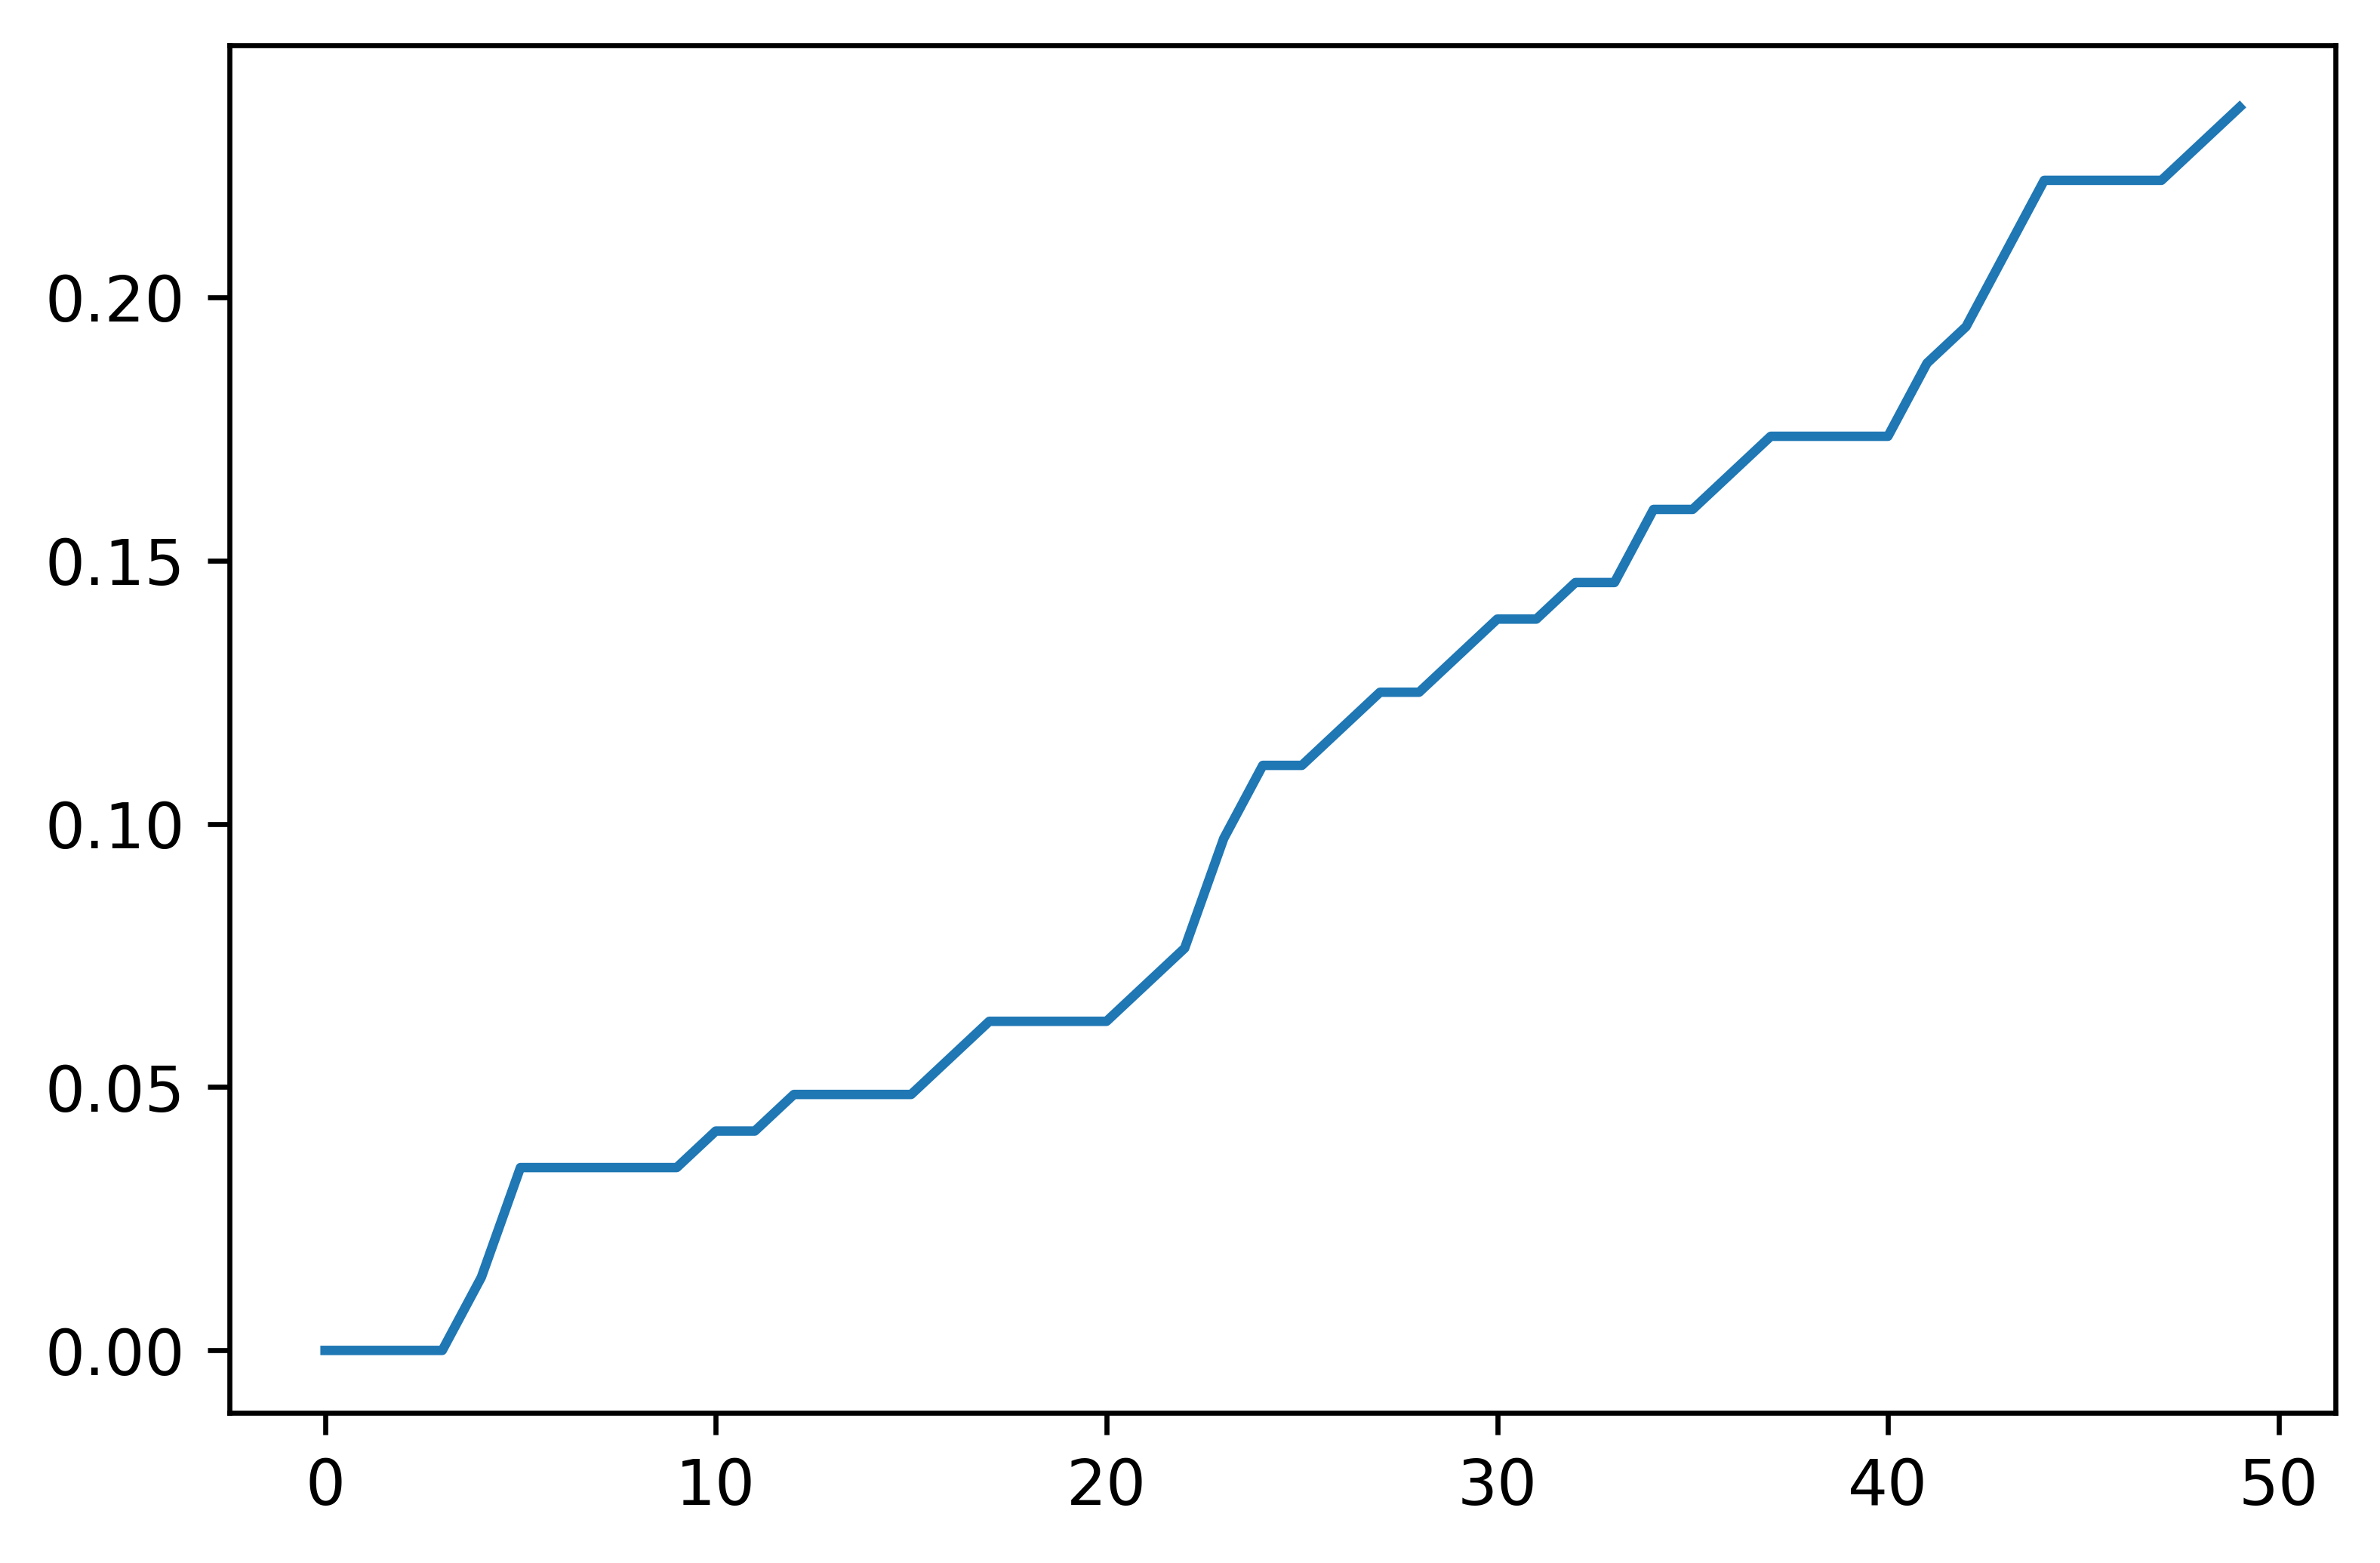

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [317]:
best_morph_embs_insp_ntk_knn_acc_results = morph_embs_insp_gs_ntk_knn_acc_results.loc[
    morph_embs_insp_gs_ntk_knn_acc_results.config_id == 392
]
best_morph_embs_insp_ntk_knn_acc_results.knn_acc.plot()

---
### INSP-adjusted image-based gene embeddings

In [280]:
img_embs_insp_gs_ntk_knn_acc_results = run_jump_gridsearch_knn_accuracy(
    pert_embs=img_embs_insp,
    reg_embs=reg_embs,
    train_targets=list(train_targets),
    test_targets=list(test_targets),
    model_type=model_type,
    model_params_dicts=model_params_dicts,
    use_y_train_mean_params=["True"],
    n_neighbors_weights_features_params=n_neighbors_weights_features_params,
    n_weight_encodings_params=n_weight_encodings_params,
    append_neighbor_embs_params=append_neighbor_embs_params,
    neighbor_weight_encoding_params=neighbor_weight_encoding_params,
    rff_sigma_params=rff_sigma_params,
    save_output_file="../../../../data/experiments/translation_results/jump/jump_img_embs_insp_gs_knn_results.pkl",
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-14-4475fae297a2>:57: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['model', 'use_mean_train_reg_embs', 'pos_encoding_type',
       'append_neighbor_embs'],
      dtype='object')]

  all_knn_acc_results.to_hdf(save_output_file, key="data")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [308]:
output_best_model_config_ids(
    results=img_embs_insp_gs_ntk_knn_acc_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=9,
)

<ipython-input-15-d52defac4be7>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = results.groupby(config_id_col).mean()


,config_id,metric,value
8,56,20nn_auc,0.037037
11,56,50nn_auc,0.080610


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

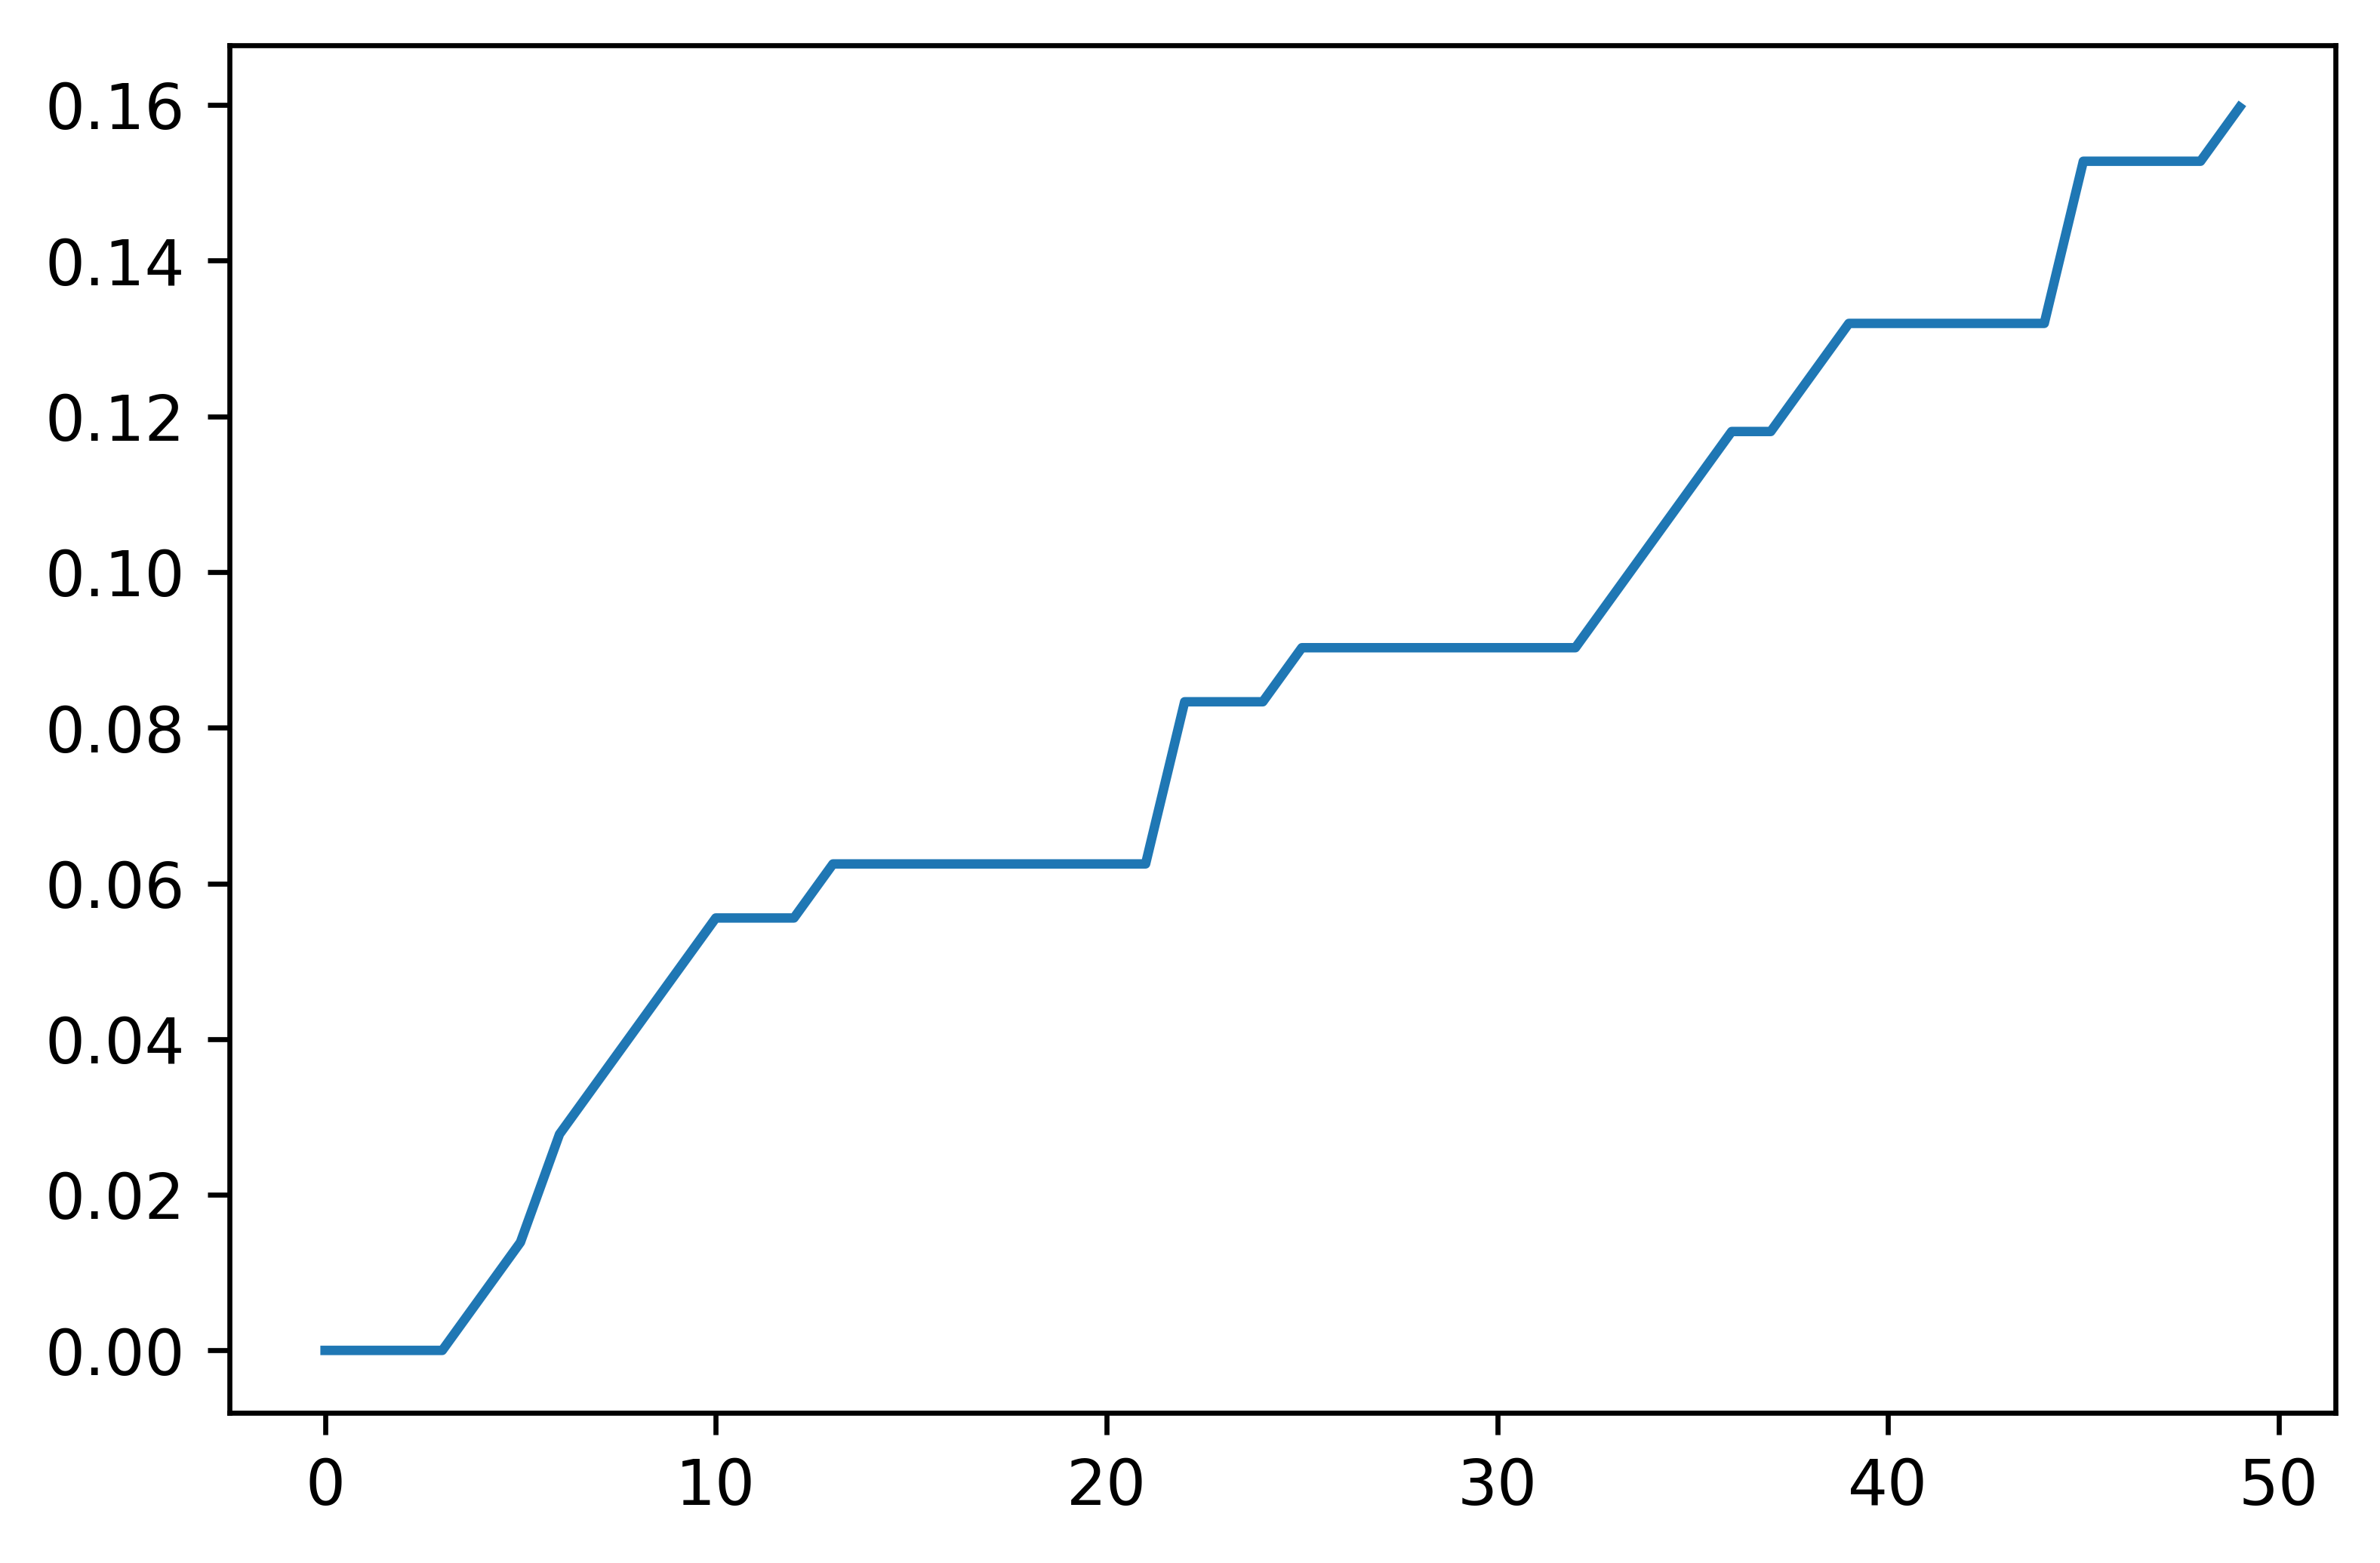

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [309]:
best_img_embs_insp_ntk_knn_acc_results = img_embs_insp_gs_ntk_knn_acc_results.loc[
    img_embs_insp_gs_ntk_knn_acc_results.config_id == 56
]
best_img_embs_insp_ntk_knn_acc_results.knn_acc.plot()

In [320]:
best_img_embs_ntk_knn_acc_results.copy()["input"] = "img_embs"
best_img_embs_bc_ntk_knn_acc_results.copy()["input"] = "img_embs_bc"
best_img_embs_insp_ntk_knn_acc_results.copy()["input"] = "img_embs_insp"
best_morph_embs_ntk_knn_acc_results.copy()["input"] = "morph_embs"
best_morph_embs_bc_ntk_knn_acc_results.copy()["input"] = "morph_embs_bc"
best_morph_embs_insp_ntk_knn_acc_results.copy()["input"] = "morph_embs_insp"

all_knn_results = pd.concat([best_img_embs_ntk_knn_acc_results, best_img_embs_bc_ntk_knn_acc_results, best_img_embs_insp_ntk_knn_acc_results, best_morph_embs_ntk_knn_acc_results, best_morph_embs_bc_ntk_knn_acc_results, best_morph_embs_insp_ntk_knn_acc_results])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [321]:
all_knn_results

,knn_acc,k,5nn_auc,10nn_auc,15nn_auc,20nn_auc,25nn_auc,30nn_auc,50nn_auc,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,input
0,0.000000,1,0.002315,0.013889,0.030382,0.045304,0.056624,0.064740,0.099129,ntk,10,False,31,20,gauss,None,1,345,img_embs
1,0.000000,2,0.002315,0.013889,0.030382,0.045304,0.056624,0.064740,0.099129,ntk,10,False,31,20,gauss,None,1,345,img_embs
2,0.000000,3,0.002315,0.013889,0.030382,0.045304,0.056624,0.064740,0.099129,ntk,10,False,31,20,gauss,None,1,345,img_embs
3,0.006944,4,0.002315,0.013889,0.030382,0.045304,0.056624,0.064740,0.099129,ntk,10,False,31,20,gauss,None,1,345,img_embs
4,0.006944,5,0.002315,0.013889,0.030382,0.045304,0.056624,0.064740,0.099129,ntk,10,False,31,20,gauss,None,1,345,img_embs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.222222,46,0.002315,0.017045,0.026042,0.033730,0.043269,0.056004,0.106481,ntk,10,True,31,5,positional,genes,10,392,morph_embs_insp
46,0.222222,47,0.002315,0.017045,0.026042,0.033730,0.043269,0.056004,0.106481,ntk,10,True,31,5,positional,genes,10,392,morph_embs_insp
47,0.222222,48,0.002315,0.017045,0.026042,0.033730,0.043269,0.056004,0.106481,ntk,10,True,31,5,positional,genes,10,392,morph_embs_insp
48,0.229167,49,0.002315,0.017045,0.026042,0.033730,0.043269,0.056004,0.106481,ntk,10,True,31,5,positional,genes,10,392,morph_embs_insp


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## Performance summary

(<Figure size 5400x3600 with 1 Axes>,
 <AxesSubplot:xlabel='k', ylabel='knn_acc'>)

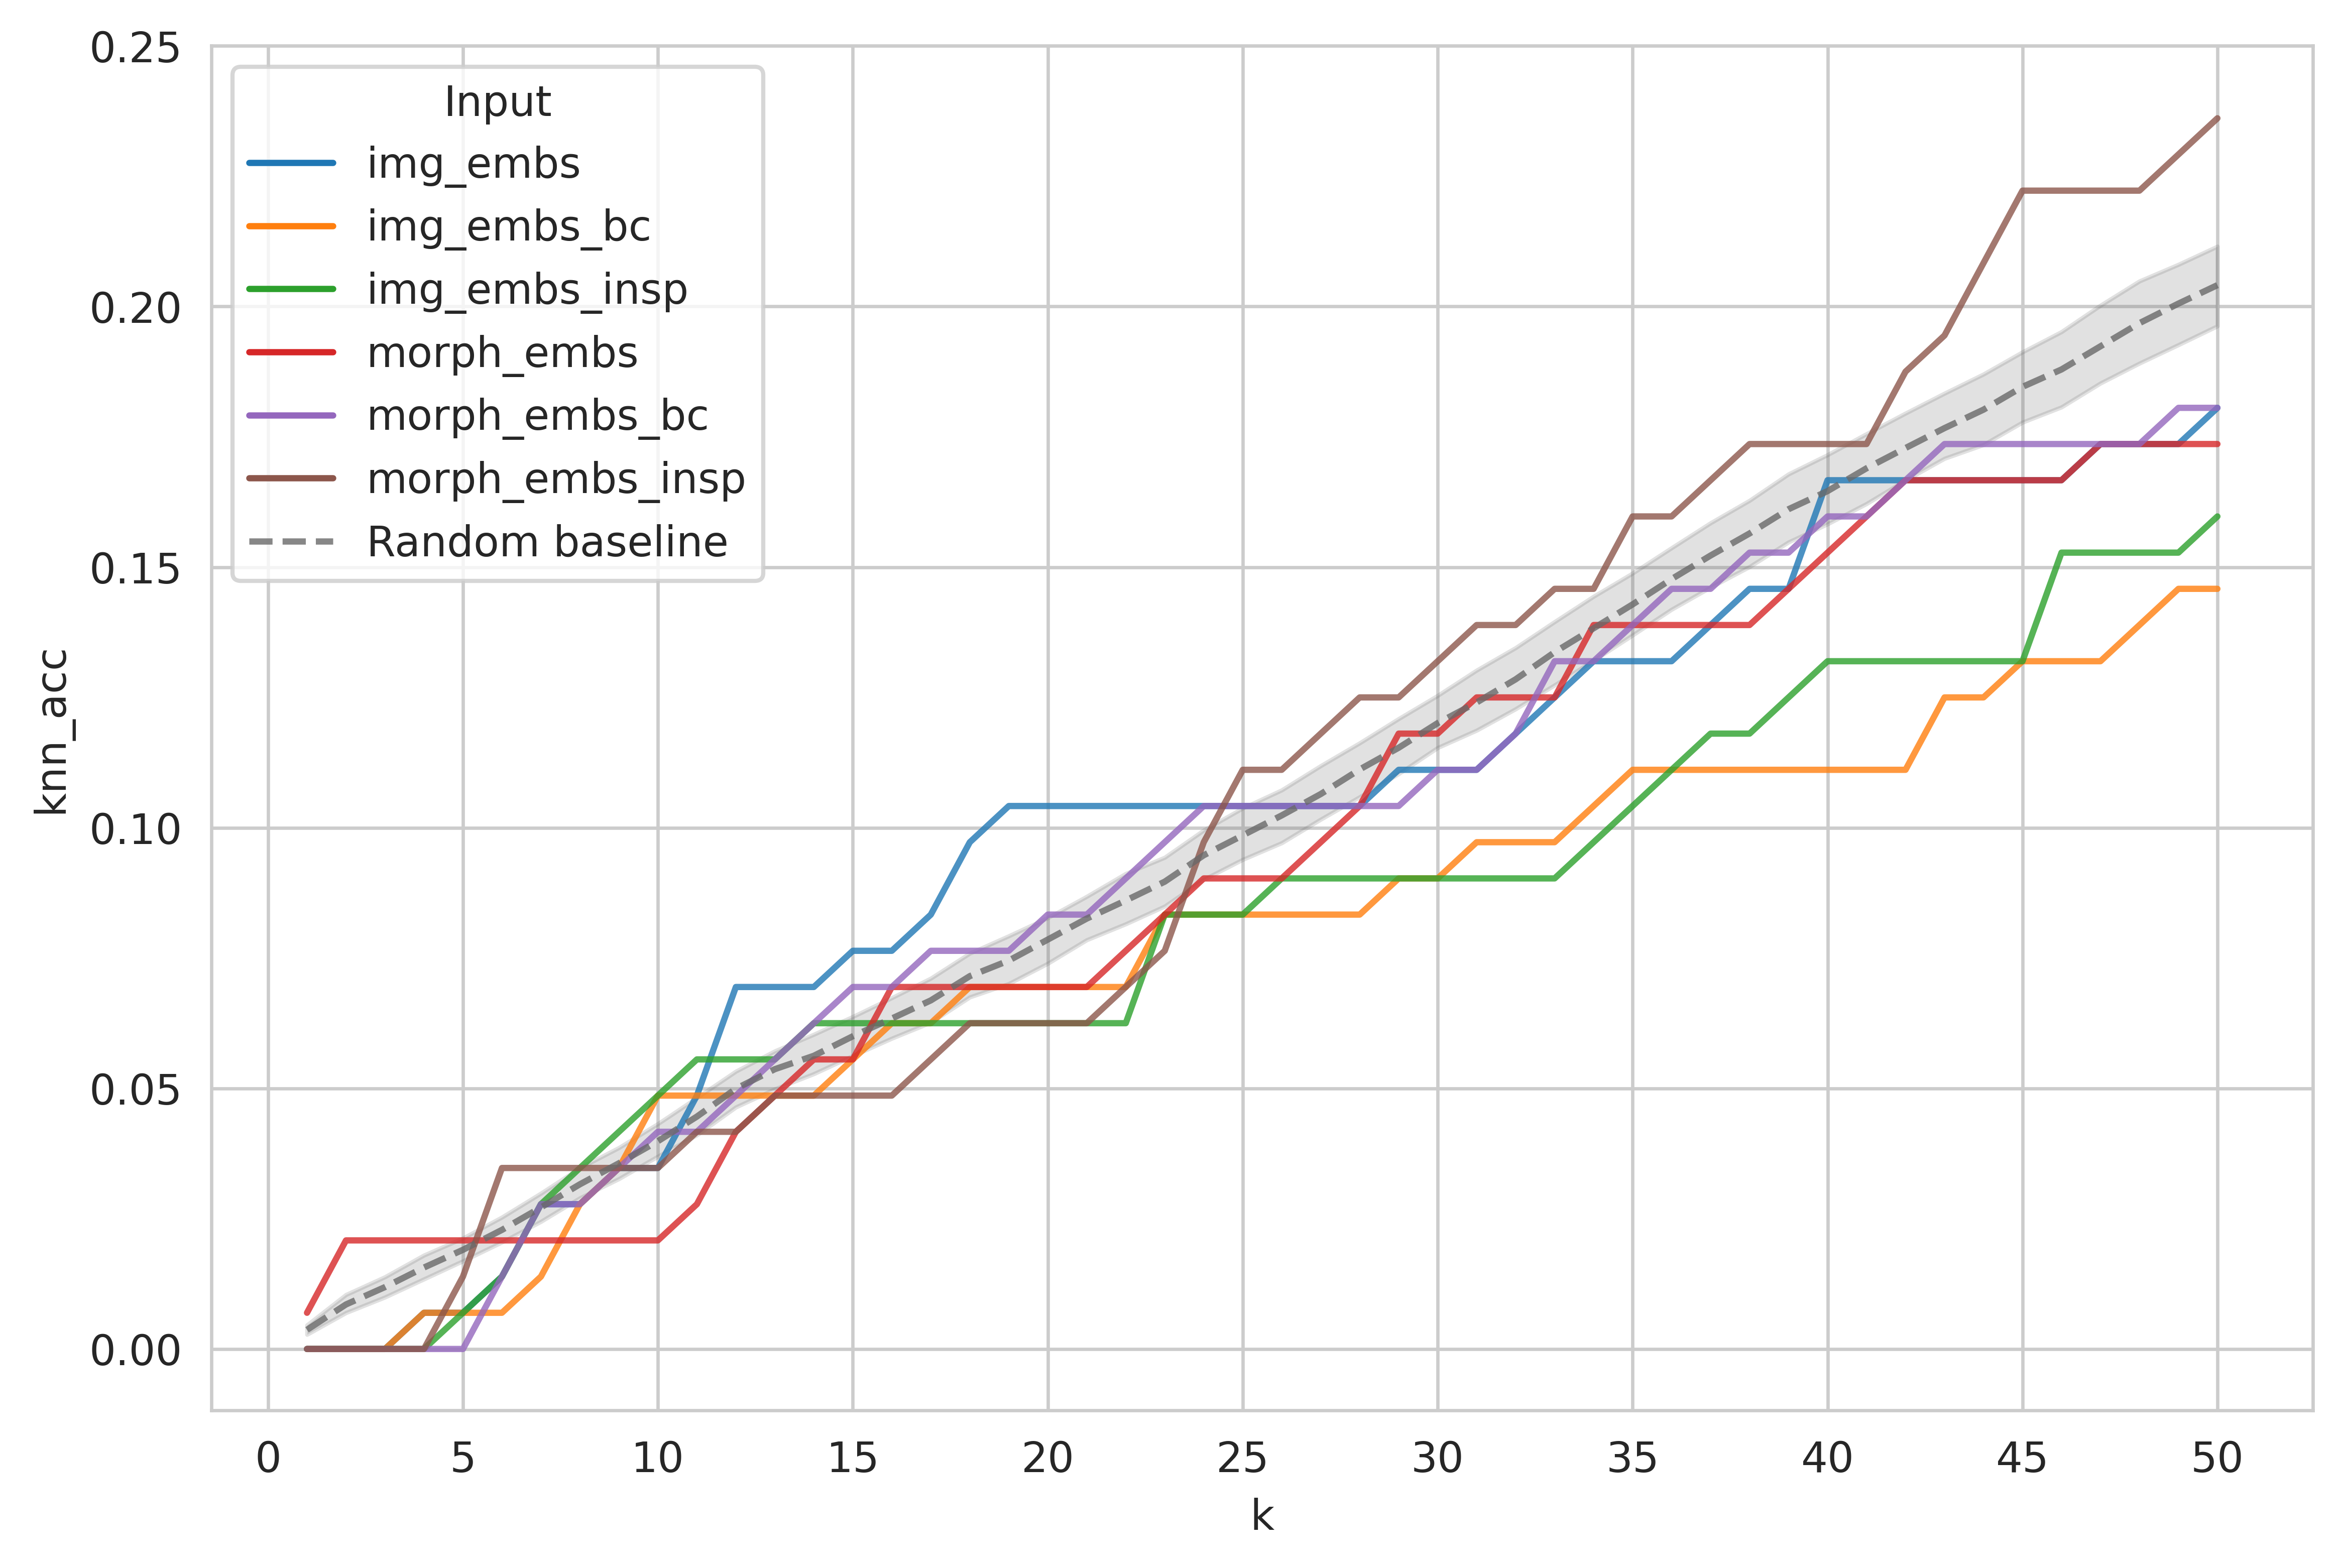

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [324]:
plot_translation_performance(
    all_knn_results,
    hue="input",
    ymax=0.3,
    title="",
    random_baseline=morph_embs_random_knn_acc_results,
    mean_baseline=None,
    mean_train_baseline=None,
    figsize=[9, 6],
    cmap=None,
    style=None,
    style_order=None,
    param_title=None,
    legend_title="Input",
    alpha=0.8,
)

---

## Data export